In [1]:
from data import datasets
import albumentations as A
from data import custum_collate
import numpy as np
import glob, cv2
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import albumentations.pytorch
import utility
import torch
import torch.distributed as dist
import torch.nn as nn

import torchvision
import os
import random
from yolox.exp import Exp
from yolox.utils import postprocess,crop_mask
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data_utils
import datetime
from shutil import copyfile
import time
import modules.evaluation as evaluate

import scipy
import torch.nn.functional as F

In [2]:
#--------------Base Param------------
w_h = [1280, 480]
BATCH_SIZE = 1
num_workers =1
file_root = '/home/user/Dataset/ETRI_Dataset/'
#--------------Base Param------------
#--------------Class Param------------
all_classes =  ['Ped', 'Cyc', 'Mobike', 'Car', 'Bus', 'Cone', 'TL','VehLane', 'OutgoLane', 'MiddleLane', 'IncomLane',  'Pav', 'Jun', 'Xing_L', 'BusStop', 'Parking_L','Red', 'Amber', 'Green', 'MovAway', 'MovTow', 'Blocking', 'Informing', 'Brake', 'Stop', 'IncatLft',
                   'IncatRht', 'HazLit', 'HeadingLft', 'HeadingRht', 'Parking', 'EmVeh', 'School', 'Control', 'Xing']
len_class = len(all_classes)
agent_classes =  ['Ped', 'Cyc', 'Mobike', 'Car', 'Bus', 'Cone', 'TL']
loc_classes =  ['VehLane', 'OutgoLane', 'MiddleLane', 'IncomLane',  'Pav', 'Jun', 'Xing_L', 'BusStop', 'Parking_L']
action_classes =  ['Red', 'Amber', 'Green', 'MovAway', 'MovTow', 'Blocking', 'Informing', 'Brake', 'Stop', 'IncatLft',
                   'IncatRht', 'HazLit', 'HeadingLft', 'HeadingRht', 'Parking', 'EmVeh', 'School', 'Control', 'Xing']
class_nums = [len(agent_classes), len(loc_classes), len(action_classes)]
#--------------Class Param------------

#--------------Learning Rate Param------------
T_0=20 # Initial Cycle Length
T_mult=2 # Cycle Length multiplier
eta_max=1e-4 # Max LR
T_up=10  # WarmUp Length
gamma=0.5 # LR reducer

start_epoch =0
num_epochs = 120
best_acc = -1

#--------------Learning Rate Param------------

In [3]:
icons = {}
for actions in action_classes:
    target = './Icons/'+actions+'.png'
    icon_img = cv2.imread(target)
    icon_img = cv2.cvtColor(icon_img, cv2.COLOR_BGR2RGB)
    icons[actions] = icon_img
    
for actions in loc_classes:
    #print(actions)
    target = './Icons/'+actions+'.png'
    icon_img = cv2.imread(target)
    icon_img = cv2.cvtColor(icon_img, cv2.COLOR_BGR2RGB)
    icons[actions] = icon_img

In [4]:

def postprocess(prediction, num_classes, conf_thre=0.1, nms_thre=0.85):
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(
            image_pred[:, 5 : 5 + 7], 1, keepdim=True
        )
        loc_conf, loc_pred = torch.max(
            image_pred[:, 5+7 : 5 + 7+9], 1, keepdim=True
        )
        action_conf, action_pred = torch.max(
            image_pred[:, 5+7+9 : 5 + 7 + 9+19], 1, keepdim=True
        )
        reid_feat  = image_pred[:,-256 : ]
        
        action_idx = (image_pred[:, 5+7+9 : 5 + 7 + 9+19]+0.6)//1
        
        conf_mask = (image_pred[:, 4] * class_conf.squeeze()>= conf_thre).squeeze()
        # _, conf_mask = torch.topk((image_pred[:, 4] * class_conf.squeeze()), 1000)
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf, class_pred.float(),loc_pred.float(),action_idx,reid_feat), 1)
        detections = detections[conf_mask]
        if not detections.size(0):
            continue

        nms_out_index = torchvision.ops.batched_nms(
            detections[:, :4],
            detections[:, 4] * detections[:, 5],
            detections.new_zeros(detections.shape[0]),
            nms_thre,
        )
        detections = detections[nms_out_index]
        if output[i] is None:
            output[i] = detections
        else:
            output[i] = torch.cat((output[i], detections))

    return output

def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or 2  # line thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=1)

COLORS =[
        [255, 0, 0],     # Red
        [0, 255, 0],     # Green
        [0, 0, 255],     # Blue
        [255, 255, 0],   # Yellow
        [255, 0, 255],   # Magenta
        [0, 255, 255],   # Cyan
        [128, 0, 0],     # Maroon
        [0, 128, 0],     # Green (dark)
        [0, 0, 128],     # Navy
        [128, 128, 0],   # Olive
        [128, 0, 128],   # Purple
        [0, 128, 128],   # Teal
        [255, 165, 0],   # Orange
        [210, 180, 140], # Tan
        [255, 192, 203], # Pink
        [0, 128, 128],   # Teal
        [255, 99, 71],   # Tomato
        [139, 69, 19],   # Saddle Brown
        [0, 128, 0],     # Green (dark)
        [255, 20, 147]   # Deep Pink
    ]
#for _ in range(len(agent_list)):
#    COLORS.append([np.random.randint(0, 255) for _ in range(3)])

In [5]:

def seg_plot_one_box(x,idx, img,cls,loc,action, mask, color=None, label=None,track_id=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or 2  # line thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    
    c1, c2 = (np.clip(int(x[0]),0,mask.shape[1]), np.clip(int(x[1]),0,mask.shape[0])), (np.clip(int(x[2]),0,mask.shape[1]), np.clip(int(x[3]),0,mask.shape[0]))
    cv2.rectangle(img, c1, c2, color, thickness=1)
    copy_mask = mask[c1[1]:c2[1],c1[0]:c2[0]]==idx
    
    mask_img = np.expand_dims(copy_mask, axis=2)
    mask_img = np.repeat(mask_img, 3, axis=2)
    #print(copy_mask.shape, COLORS[idx%])
    if track_id==None:
        img[c1[1]:c2[1],c1[0]:c2[0],:][copy_mask,:]= img[c1[1]:c2[1],c1[0]:c2[0],:][copy_mask,:]*0.6 + np.array(COLORS[idx%20])*0.4
    else:
        img[c1[1]:c2[1],c1[0]:c2[0],:][copy_mask,:]= img[c1[1]:c2[1],c1[0]:c2[0],:][copy_mask,:]*0.6 + np.array(COLORS[track_id%20])*0.4
        
    
    agent_list = ['Ped', 'Cyc', 'Mobike', 'Car', 'Bus', 'Cone', 'TL']
    loc_list = ['VehLane', 'OutgoLane', 'MiddleLane', 'IncomLane',  'Pav', 'Jun', 'Xing_L', 'BusStop', 'Parking_L']
    action_list = ['Red', 'Amber', 'Green', 'MovAway', 'MovTow', 'Blocking', 'Informing', 'Brake', 'Stop', 'IncatLft',
                   'IncatRht', 'HazLit', 'HeadingLft', 'HeadingRht', 'Parking', 'EmVeh', 'School', 'Control', 'Xing']
    
    num_icon = np.sum(action)
    if cls==6:
        icon_size = int(np.min([(c2[0]-c1[0])/(num_icon+1),(x[3]-x[1]),64]))
    elif cls==0 or cls==5:
        icon_size = int(np.min([(c2[0]-c1[0])/num_icon,(x[3]-x[1]),64]))

    else:
        icon_size = int(np.min([(c2[0]-c1[0])/num_icon,(x[3]-x[1])/2,64]))
    c3 = c1[0]#+(c2[0]-c1[0])//2-icon_size*num_icon//2

    try:
        offset_icon = 0
        for ii in range(len(action)):
            if action[ii]==1:
                if cls == 0 or cls==6 or cls==5:
                    img[c1[1]-icon_size:c1[1],c3+offset_icon:c3+offset_icon+icon_size,:] = cv2.resize(icons[action_list[ii]],(icon_size,icon_size),interpolation=cv2.INTER_NEAREST )*0.5+img[c1[1]-icon_size:c1[1],c3+offset_icon:c3+offset_icon+icon_size,:]*0.5
                else:
                    img[c1[1]:c1[1]+icon_size,c3+offset_icon:c3+offset_icon+icon_size,:] = cv2.resize(icons[action_list[ii]],(icon_size,icon_size),interpolation=cv2.INTER_NEAREST )*0.5+img[c1[1]:c1[1]+icon_size,c3+offset_icon:c3+offset_icon+icon_size,:]*0.5
                offset_icon+=icon_size

        if cls==6:
            img[c1[1]-icon_size:c1[1],c3+offset_icon:c3+offset_icon+icon_size,:] = cv2.resize(icons[loc_list[loc]],(icon_size,icon_size))*0.5+img[c1[1]-icon_size:c1[1],c3+offset_icon:c3+offset_icon+icon_size,:]*0.5
        else:
            img[c2[1]-icon_size:c2[1],c3:c3+icon_size,:] = cv2.resize(icons[loc_list[loc]],(icon_size,icon_size))*0.5+img[c2[1]-icon_size:c2[1],c3:c3+icon_size,:]*0.5

    except:
        pass



In [6]:
#Train transfrom + Augmentations

train_transform =  A.Compose(
    [
    A.Normalize(mean=(0,0,0),std=(1,1,1)),
    #A.Normalize(),
    A.pytorch.transforms.ToTensorV2()],
    bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']),
)

transform = A.Compose(
    [
    A.Normalize(mean=(0,0,0),std=(1,1,1)),
    A.pytorch.transforms.ToTensorV2()]
)
train_dataset = datasets.Infra_dataset(train=True,class_nums = class_nums,transform=train_transform,file_root = file_root)
train_data_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers,collate_fn=custum_collate, pin_memory=True, drop_last=True)
val_dataset = datasets.Infra_dataset(train=False,class_nums = class_nums,self_train=False,transform=train_transform,file_root = file_root)



dataset length :  45158 45158
dataset length :  8501 8501


In [9]:
#Model Create

exp = Exp(class_nums = class_nums)
model = exp.get_model()
#model = load_my_state_dict(model,ckpt["model"])
#ckpt = torch.load('/home/etri/road-dataset/Track_YOLOX/last.ckpt')
#model = utility.load_my_state_dict(model,ckpt["state_dict"])

#ckpt = torch.load('./output/2024-03-07-18-25-00/checkpoints/best.pth.tar', map_location='cpu')
#ckpt = torch.load('./output/2024-03-20-13-29-27/checkpoints/best.pth.tar', map_location='cpu')
ckpt = torch.load('./output/Overfit/checkpoints/best.pth.tar', map_location='cpu')
model = utility.load_my_state_dict(model,ckpt['state_dict'])

In [10]:
tl = iter(train_data_loader)

In [11]:
exp = Exp()
model.cuda()
model.eval()

YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (conv2): BaseConv(
            (conv): Conv2d(128, 64, kernel

In [12]:
import shutil 
import time
try: 
    shutil.rmtree('./Result/')
    print("Removed New dir")
except:
    print("Making New dir")

filepath = './Result/'
if not os.path.exists(os.path.dirname(filepath)):
    try:
        os.makedirs(os.path.dirname(filepath))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

Making New dir


/tmp/ipykernel_587132/51065904.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  semseg = torch.nn.functional.softmax(torch.einsum("cq,qhw->chw", target_vec, target_mask))


torch.Size([17, 120, 320])


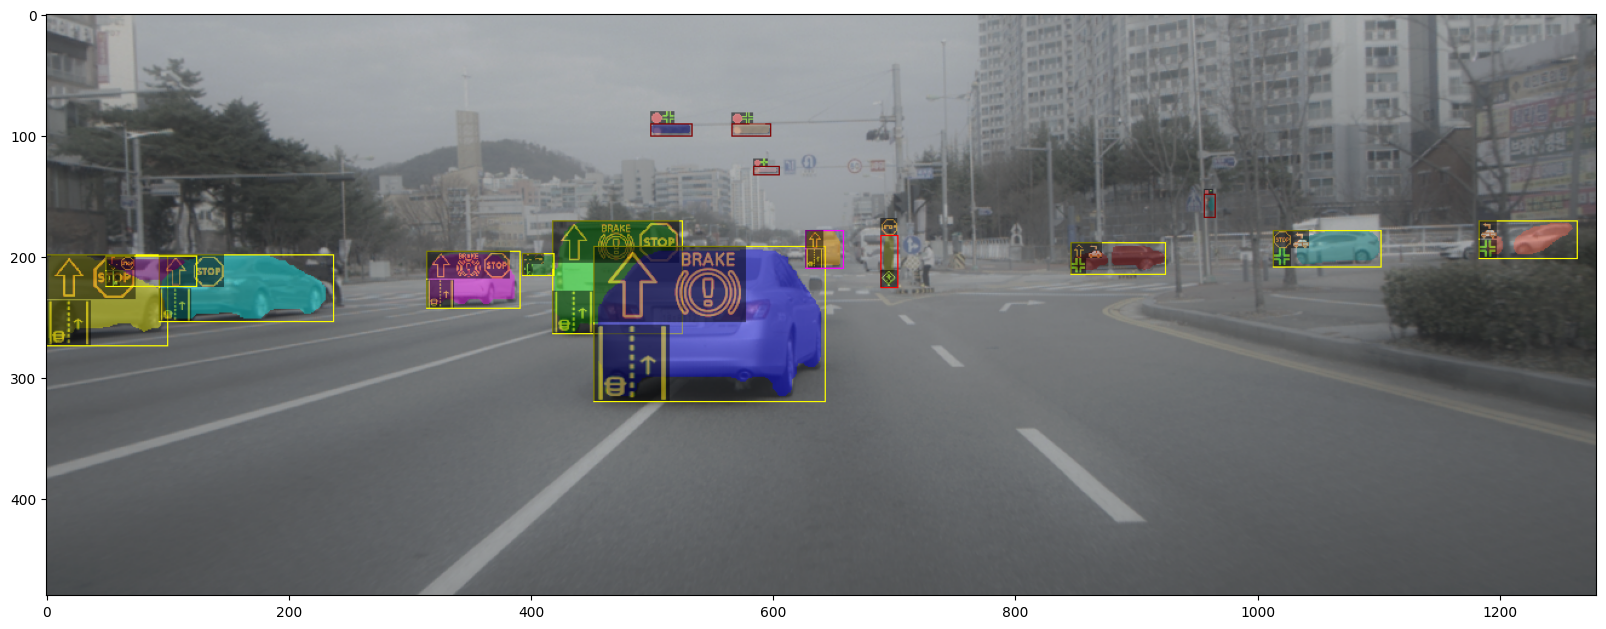

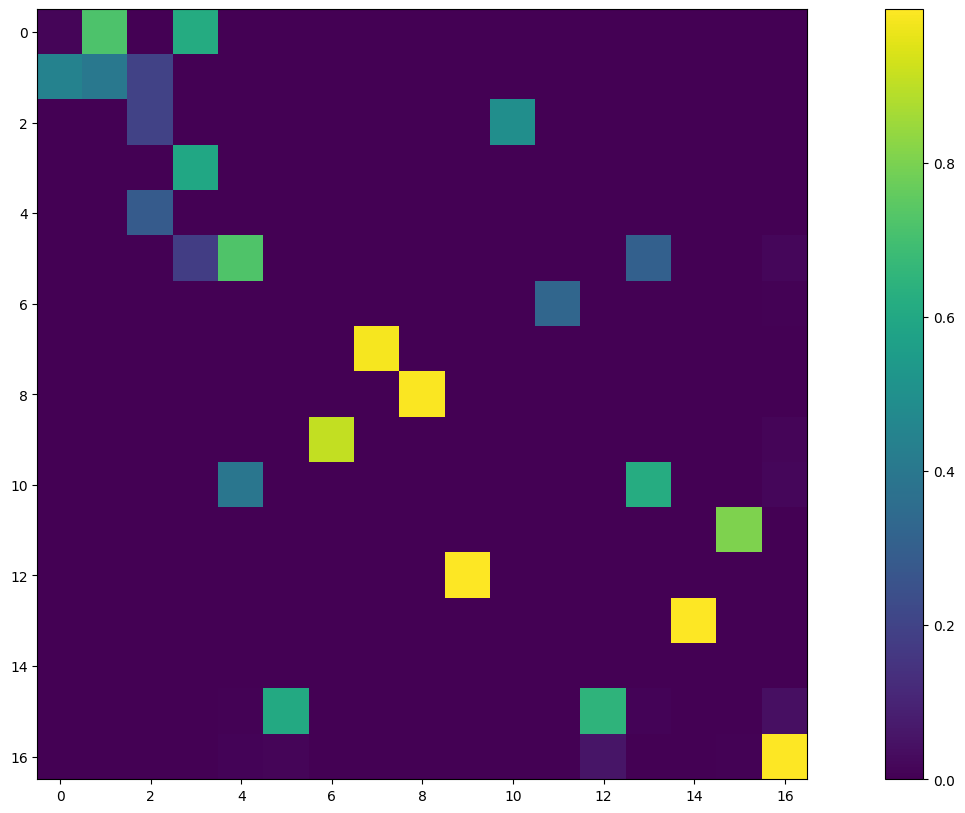

torch.Size([17, 120, 320])


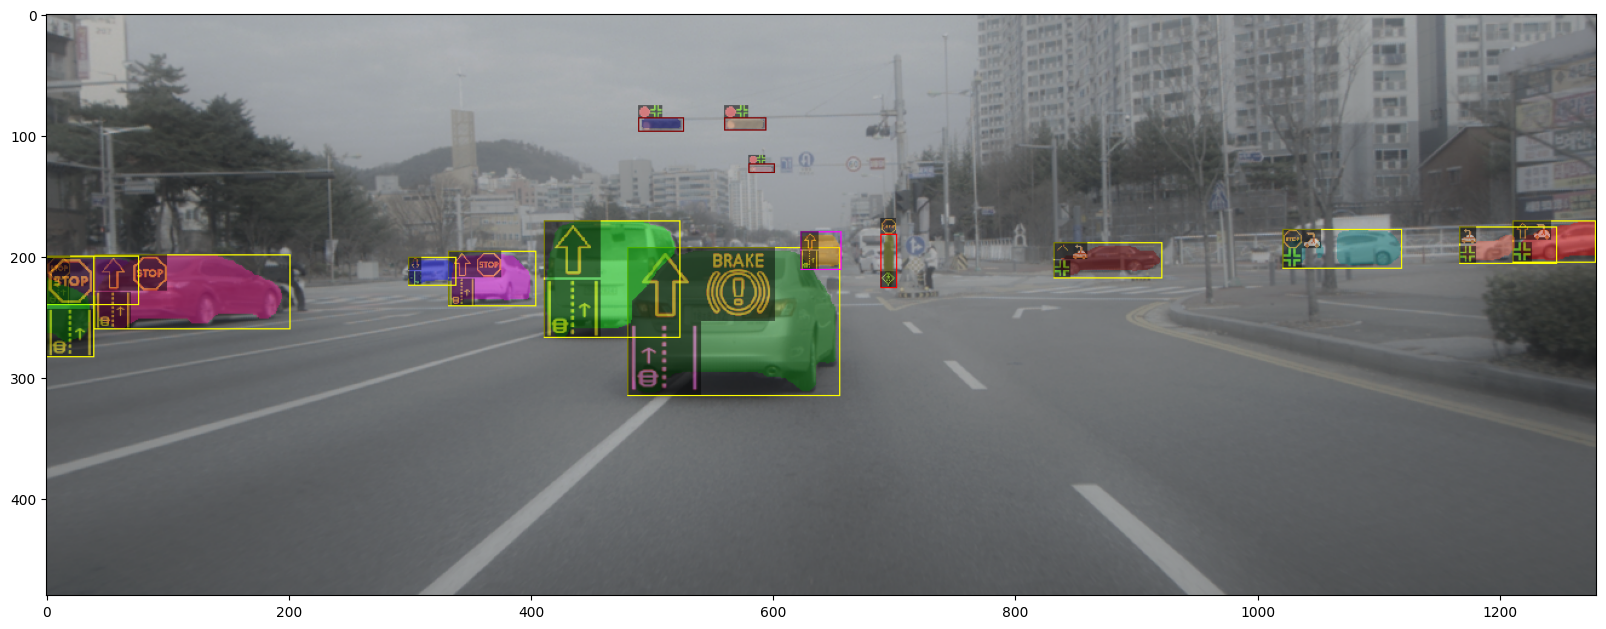

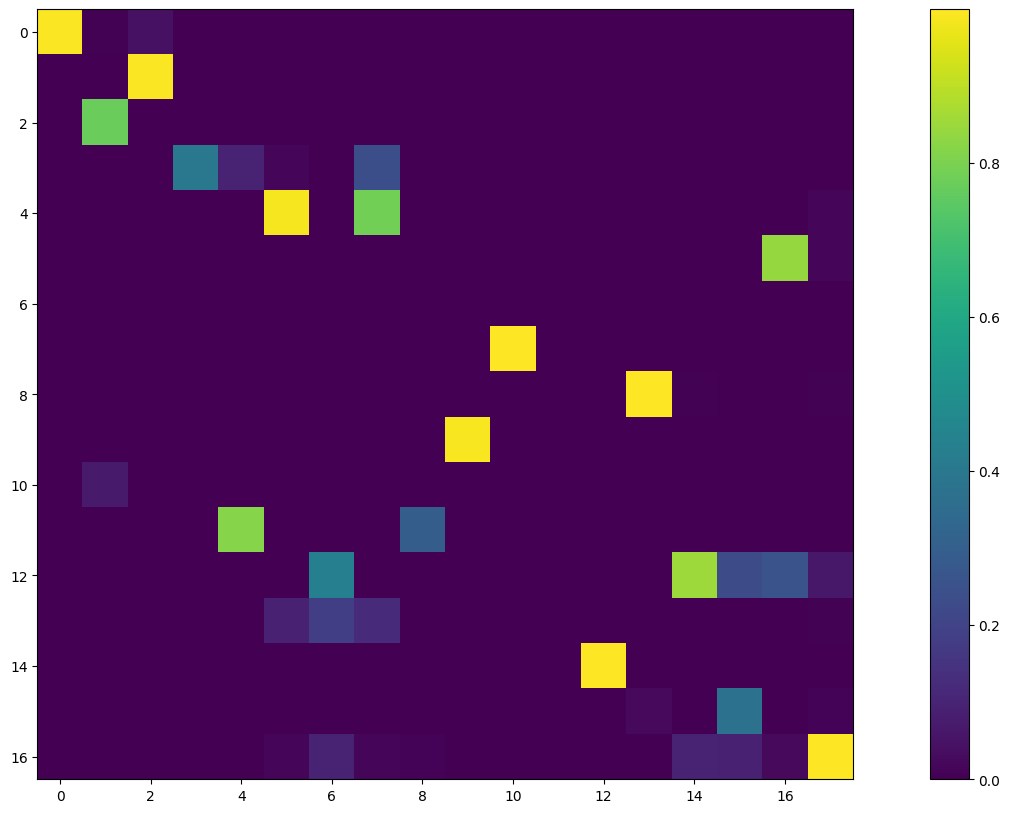

torch.Size([18, 120, 320])


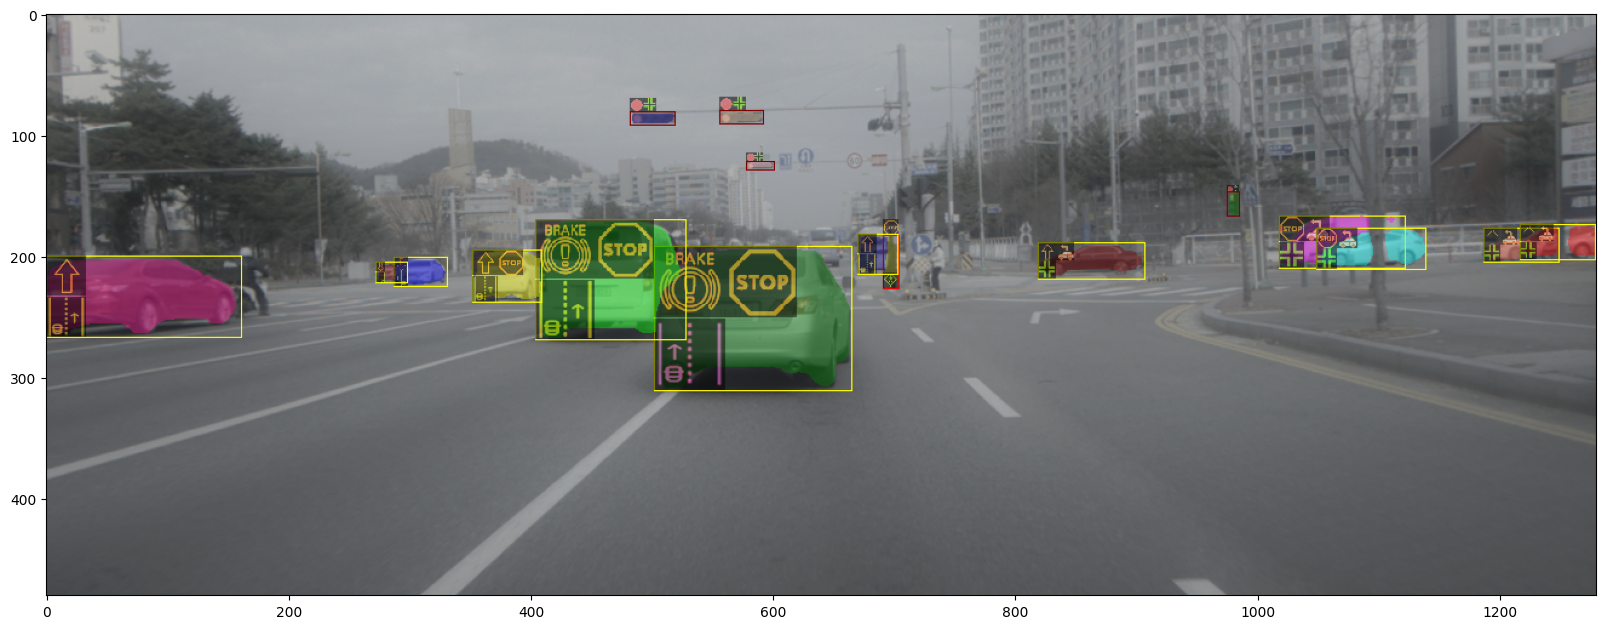

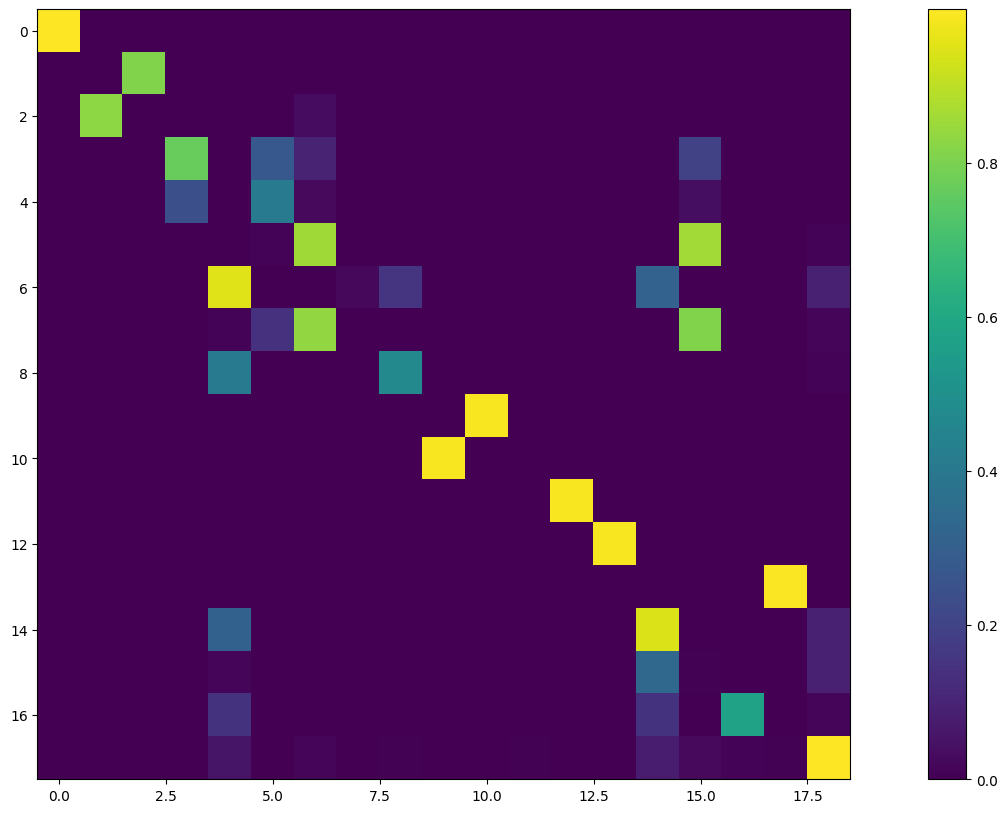

torch.Size([19, 120, 320])


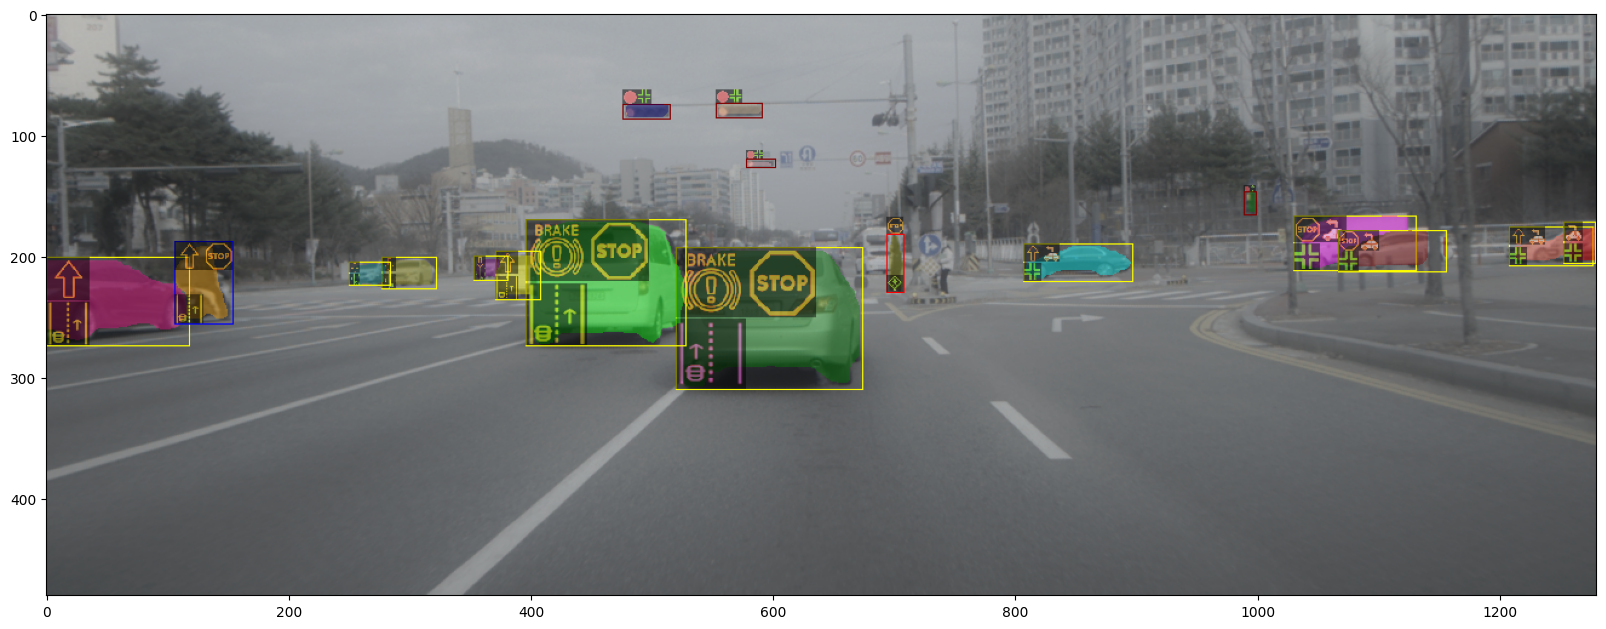

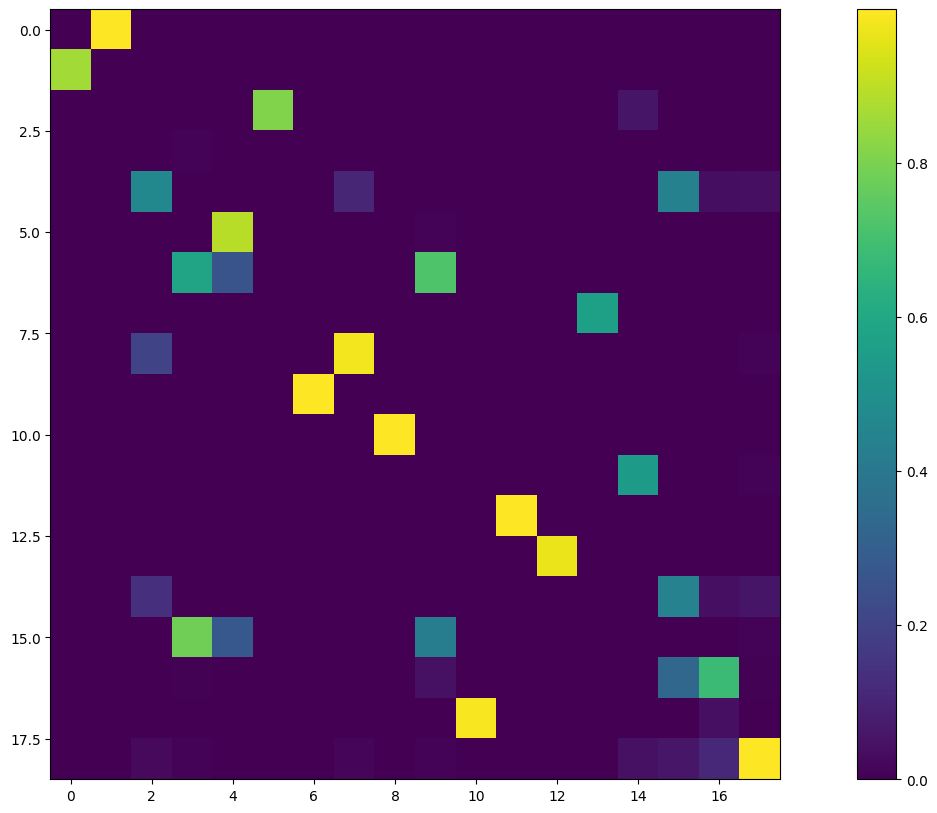

torch.Size([18, 120, 320])


KeyboardInterrupt: 

In [15]:
count = 0
frame_num = 0
write=False
t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
old_reid_feat = []
reid_feat = []
track_num = 1
track_thresh = 0.5
target_folder = '/home/user/Dataset/RawImg/OiSam_Day/'
searchLabel = sorted(os.listdir(target_folder))
with torch.no_grad():
    for jj in range(len(searchLabel)-1):
        if jj%3==0 and jj>3000:
            #===============================
            t1.append(time.time())
            #===============================




            img_name = target_folder + '/' + searchLabel[jj]
            #print(img_name)
            img = cv2.imread(img_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            clip = transform(image=img)

            images = clip['image'].unsqueeze(0)

            height, width = images.shape[-2:]
            wh = [height, width]
            images = images.cuda(0, non_blocking=True)

            #===============================
            t2.append(time.time())
            #===============================
            output = model(images)
            result,re_mask,bg_vector = output['results'],output['mask_output'],output['bg_vector']
            #print(result.shape,re_mask.shape,bg_vector.shape)
            #===============================
            t3.append(time.time())
            #===============================
            outputs = postprocess(result, 35, 0.1,0.5)[0]
            #===============================

            t4.append(time.time())
            #====================================================
            target_mask = re_mask[0,:,:,:]     
            #print(target_mask.shape)
            #plt.rcParams['figure.figsize'] = [10,10]
            #plt.imshow(torch.norm(target_mask,dim=0).cpu().numpy())
            #plt.colorbar()
            #plt.show() 
            target_img = img[:,:,:]
            if outputs!=None:
                
                target_vec = torch.cat((outputs[:,-256:],bg_vector.unsqueeze(0)),dim=0)
                #print(outputs.shape)
                if track_num==1:
                    naming_num = np.arange(outputs.shape[0]+1.0)+track_num
                    track_num += (outputs.shape[0]+1)
                    if len(old_reid_feat) == 0:
                        old_reid_feat = torch.nn.functional.normalize(target_vec, p=2.0, dim=1)
                else:
                    old_naming_num = naming_num
                    naming_num = np.zeros(outputs.shape[0]+1)

                    if len(old_reid_feat) == 0:
                        old_reid_feat = torch.nn.functional.normalize(target_vec, p=2.0, dim=1)
                    reid_feat = torch.nn.functional.normalize(target_vec, p=2.0, dim=1)
                    conf_mat = torch.matmul(old_reid_feat,torch.transpose(reid_feat, 0, 1))
                    
                    
                    if write==False:
                        plt.imshow(conf_mat.cpu().numpy())
                        plt.colorbar()
                        plt.show()
                    
                    row, col = scipy.optimize.linear_sum_assignment(conf_mat.cpu().numpy(), maximize=True) 
                    order = torch.argsort(conf_mat[row,col], descending=True)


                    for ii in order:
                        target = ii.item()
                        #print(conf_mat[row[ii],col[ii]],naming_num[col[ii]])
                        #print(conf_mat[row[target],col[target]], row[target],col[target])
                        if conf_mat[row[target],col[target]]>track_thresh :
                            if naming_num[col[target]]==0:
                                naming_num[col[target]]=old_naming_num[row[target]]
                                #reid_feat[col[target],:] = reid_feat[col[target],:]*1.25 - old_reid_feat[row[target],:]*0.25
                                old_naming_num[row[target]] = 0
                            else:
                                print("Noooooooooooo")
                                old_naming_num[row[target]] = -1

                    old_reid_feat = reid_feat

                    for ii in range(outputs.shape[0]):
                        if naming_num[ii]==0:
                            naming_num[ii]=track_num
                            track_num+=1

                #print(naming_num)

                downsampled_bboxes = outputs[:,0:4].clone()
                downsampled_bboxes[:, 0] *= 0.25
                downsampled_bboxes[:, 2] *= 0.25
                downsampled_bboxes[:, 3] *= 0.25
                downsampled_bboxes[:, 1] *= 0.25
                downsampled_bboxes = torch.cat((downsampled_bboxes, torch.tensor([[0,0,width*0.25,height*0.25]]).to(downsampled_bboxes.device)) ,dim=0)

                semseg = torch.nn.functional.softmax(torch.einsum("cq,qhw->chw", target_vec, target_mask))

                semseg = crop_mask(semseg, downsampled_bboxes)
                #print(semseg.shape)
                soft_seg = torch.nn.functional.interpolate(semseg.unsqueeze(0),size=(semseg.shape[1]*4,semseg.shape[2]*4),
                                                                 mode='bilinear', align_corners=True).squeeze(0)
                '''
                for ii in range(soft_seg.shape[0]):
                    plt.imshow(soft_seg.cpu().numpy()[ii,:,:])
                    plt.colorbar()
                    plt.show()
                '''
                max_val, max_idx= torch.max(soft_seg,0)
                '''
                plt.rcParams['figure.figsize'] = [10,10]
                plt.imshow(max_idx.cpu().numpy())
                plt.show() 
                '''
                target_outputs = outputs.cpu().numpy()

                xyxy = target_outputs[:,0:4]
                cls = target_outputs[:,6].astype('int')
                loc = target_outputs[:,7].astype('int')
                action = target_outputs[:,8:].astype('int')

                #seg_result = max_idx.cpu().numpy()
                #Lab = np.reshape(np.take(np.array(COLORS), (seg_result%20).flat, axis=0),[seg_result.shape[0], seg_result.shape[1], 3])
                #plt.rcParams['figure.figsize'] = [10,10]
                #plt.imshow(Lab)
                #plt.show() 

                for i in range(xyxy.shape[0]):
                    #print(naming_num[i])

                    seg_plot_one_box(xyxy[i],i, target_img,cls[i],loc[i],action[i],max_idx.cpu().numpy(),track_id = int(naming_num[i]), color=COLORS[cls[i]])


            if write==True:
                target_img = target_img[:, :, ::-1].copy()

                path = './Result/'+str(jj).zfill(6)+'.png'
                cv2.imwrite(path,target_img)
            else:
                plt.rcParams['figure.figsize'] = [20,10]
                plt.imshow(target_img)
                plt.show()   
                
            
            

In [17]:
print(outputs.shape)

torch.Size([12, 283])


In [ ]:
#print('Read Image and register:' , np.median((np.array(t1)-np.array(t0))))
print('Register to GPU        :' , np.median((np.array(t2)-np.array(t1))))
print('Run model              :' , np.median((np.array(t3)-np.array(t2))))
print('Post Process           :' , np.median((np.array(t4)-np.array(t3))))
#print('Tracking               :' , np.median((np.array(t5)-np.array(t4))))
#print('Total Result           :' , np.median((np.array(t5)-np.array(t0))))
#print('total images : ', idx)

In [ ]:
Register to GPU        : 0.018883943557739258
Run model              : 0.01466679573059082
Post Process           : 0.0007829666137695312

In [ ]:
#--------Data Loader------------------#
with torch.no_grad():
    img,mask, box,cls,_,_  = next(tl)
    
    gt = mask[0,:,:].numpy()
    Lab = np.reshape(np.take(np.array(COLORS), ((gt-1)%20).flat, axis=0),
                      [gt.shape[0], gt.shape[1], 3])
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(Lab)
    plt.show() 
    #if len(box[:])
    #print(img.shape, box.shape, cls.shape)
    #print(box[0].shape)
    result,re_mask,bg_vector = model(img.float().cuda(),mask.cuda(), box.cuda(),cls.cuda())
    outputs = postprocess(result, 35, 0.1,0.1)[0]
    
    target_mask = re_mask[0,:,:,:]
    target_vec = torch.cat((outputs[:,-256:],bg_vector.unsqueeze(0)),dim=0)
    semseg = torch.einsum("cq,qhw->chw", target_vec, target_mask)
    soft_seg = torch.nn.functional.interpolate(torch.nn.functional.softmax(semseg,dim=0).unsqueeze(0),size=(semseg.shape[1]*8,semseg.shape[2]*8),
                                                     mode='bilinear', align_corners=True).squeeze(0)
    max_val, max_idx= torch.max(soft_seg,0)

    target_outputs = outputs.cpu().numpy()
    target_img = (img[0,:,:,:].numpy().transpose(1, 2, 0)*255).astype(np.int16).copy()
    
    xyxy = target_outputs[:,0:4]
    cls = target_outputs[:,6].astype('int')
    loc = target_outputs[:,7].astype('int')
    action = target_outputs[:,8:].astype('int')
    
    seg_result = max_idx.cpu().numpy()
    Lab = np.reshape(np.take(np.array(COLORS), (seg_result%20).flat, axis=0),
                      [seg_result.shape[0], seg_result.shape[1], 3])
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(Lab)
    plt.show() 

    for i in range(xyxy.shape[0]):
        #print(i)

        seg_plot_one_box(xyxy[i],i, target_img,max_idx.cpu().numpy(), color=COLORS[cls[i]])


    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(target_img)
    plt.show() 


In [ ]:
np.unique(seg_result)

In [ ]:
print(max_idx.cpu().numpy().shape)

In [ ]:
with torch.no_grad():
    img,mask, box,cls,_,_  = next(tl)
    #if len(box[:])
    #print(img.shape, box.shape, cls.shape)
    #print(box[0].shape)
    result,re_mask,bg_vector = model(img.float().cuda(),mask.cuda(), box.cuda(),cls.cuda())
    outputs = postprocess(result, 35, exp.test_conf, exp.nmsthre)[0]
    
    target_mask = re_mask[0,:,:,:]
    target_vec = torch.cat((outputs[:,-256:],bg_vector.unsqueeze(0)),dim=0)
    semseg = torch.einsum("cq,qhw->chw", target_vec, target_mask)
    soft_seg = torch.nn.functional.interpolate(torch.nn.functional.softmax(semseg,dim=0).unsqueeze(0),size=(semseg.shape[1]*8,semseg.shape[2]*8),
                                                     mode='bilinear', align_corners=True).squeeze(0)
    max_val, max_idx= torch.max(soft_seg,0)

    target_outputs = outputs.cpu().numpy()
    target_img = (img[0,:,:,:].numpy().transpose(1, 2, 0)*255).astype(np.int16).copy()
    
    xyxy = target_outputs[:,0:4]
    cls = target_outputs[:,6].astype('int')
    loc = target_outputs[:,7].astype('int')
    action = target_outputs[:,8:].astype('int')
    


    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(target_img)
    plt.show() 

    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(max_idx.cpu().numpy())
    plt.show() 

    for ii in np.unique(max_idx.cpu().numpy()):
        target_img[max_idx.cpu().numpy()==ii,:] =target_img[max_idx.cpu().numpy()==ii,:]*0.7+ np.array(COLORS[ii%7])*0.3
        
    
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(target_img)
    plt.show() 


In [26]:
print(target_img.shape)

(480, 1280, 3)


In [24]:
with torch.no_grad():
    img,mask, box,cls,_,_  = next(tl)
    #if len(box[:])
    #print(img.shape, box.shape, cls.shape)
    #print(box[0].shape)
    result,re_mask,bg_vector = model(img.float().cuda(),mask.cuda(), box.cuda(),cls.cuda())
    outputs = postprocess(result, 35, exp.test_conf, exp.nmsthre)[0]
    


/tmp/ipykernel_1883958/2907656426.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  action_idx = (image_pred[:, 5+7+9 : 5 + 7 + 9+19]+0.6)//1


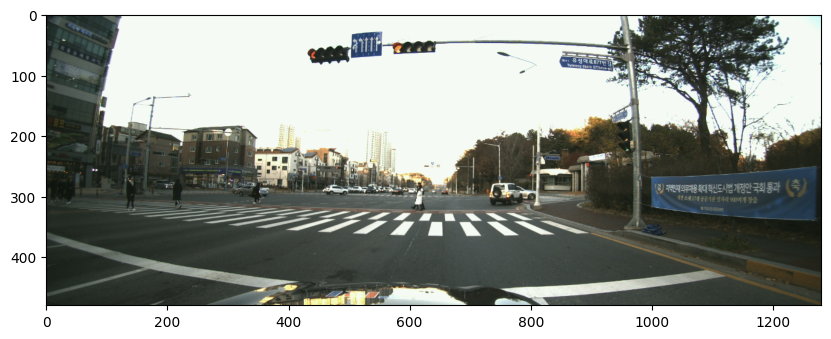

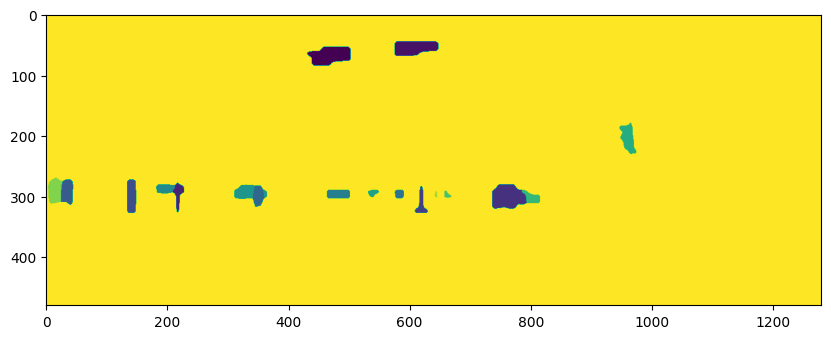

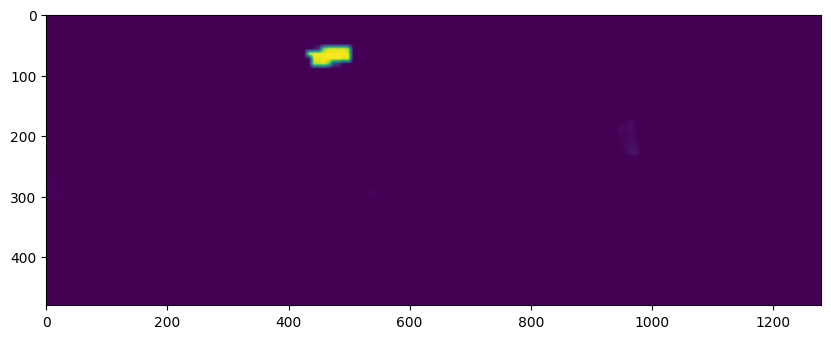

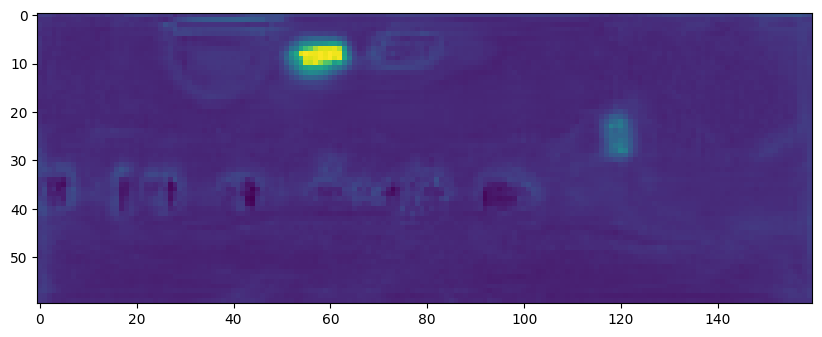

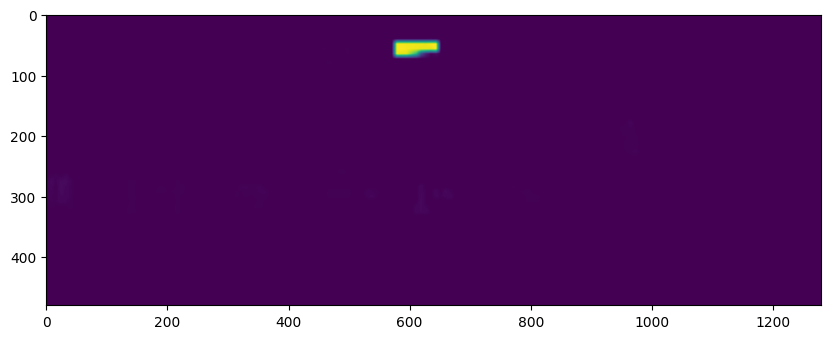

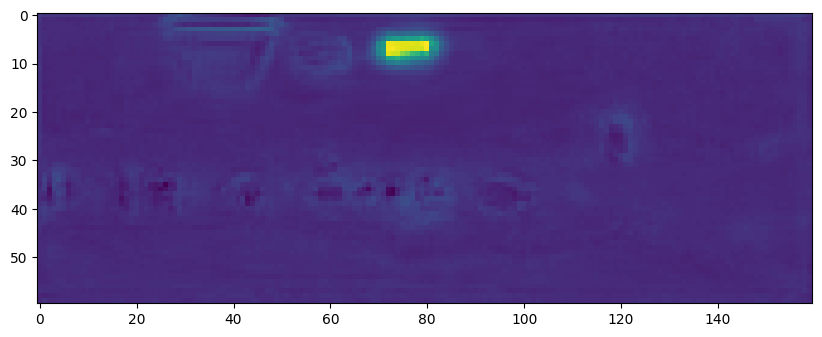

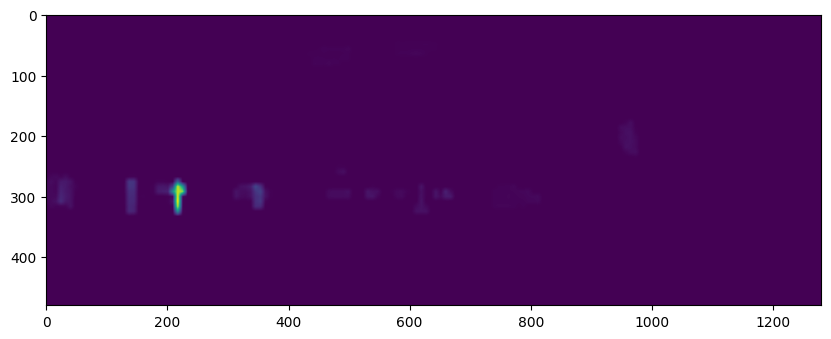

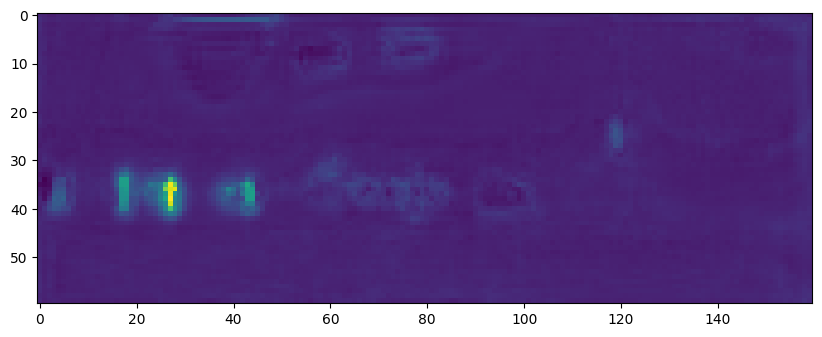

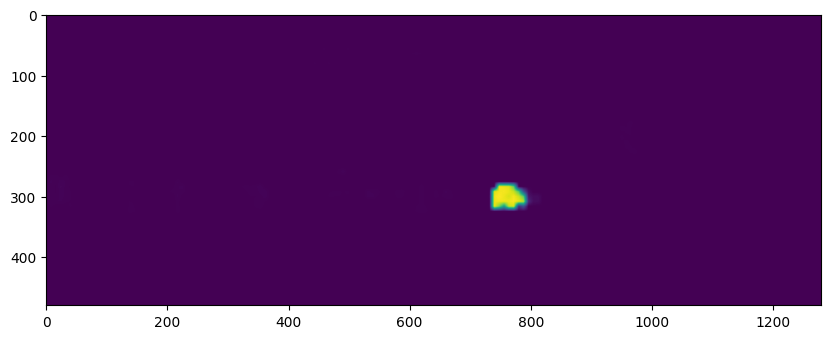

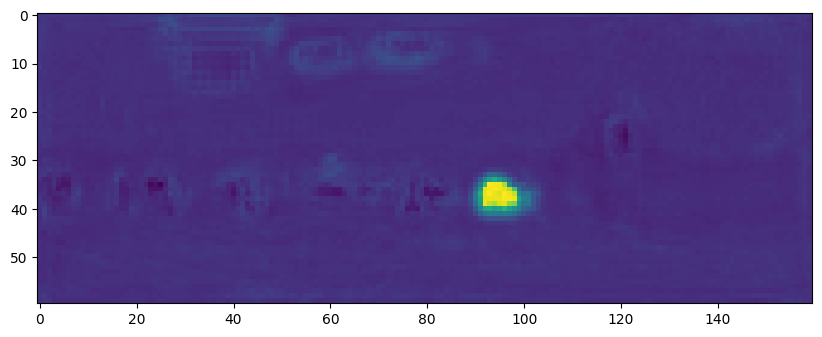

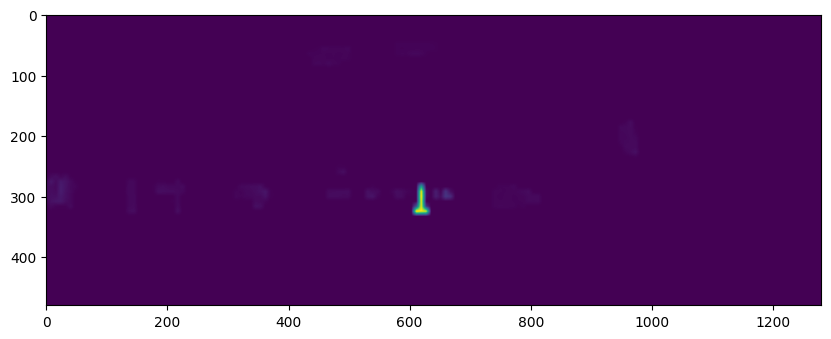

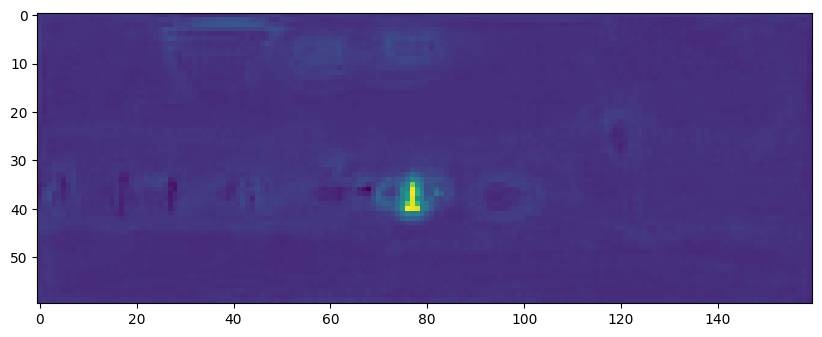

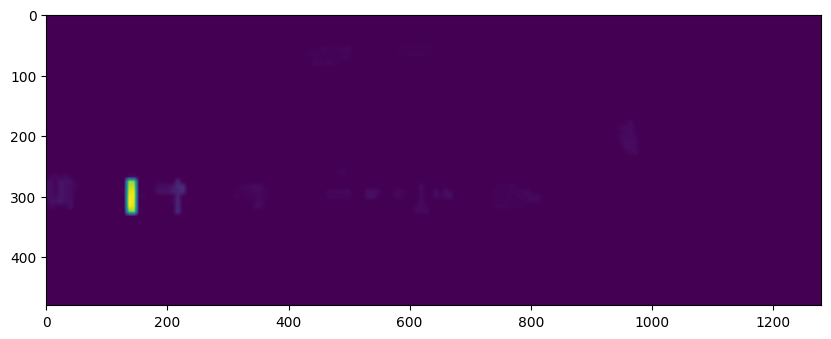

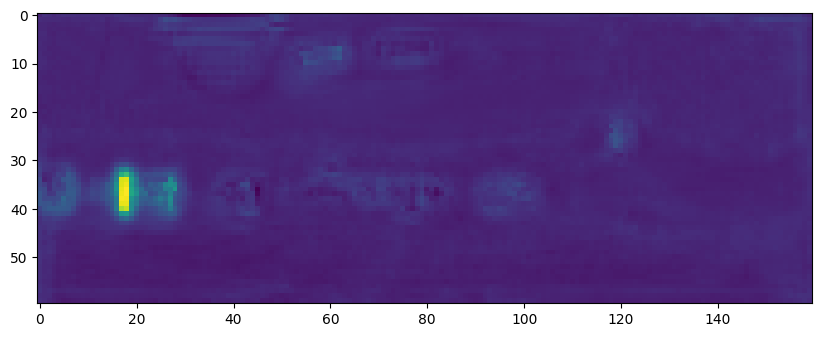

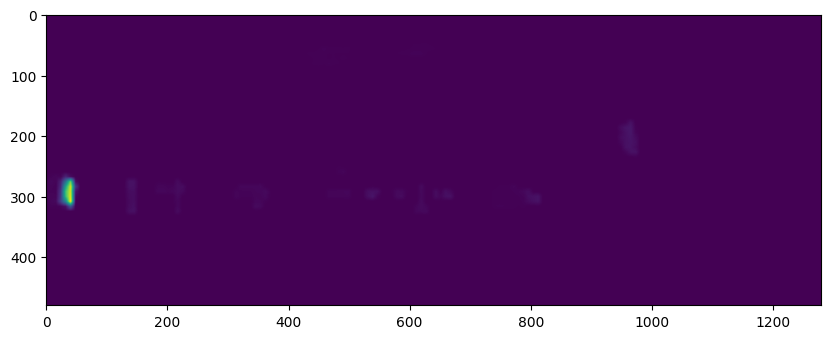

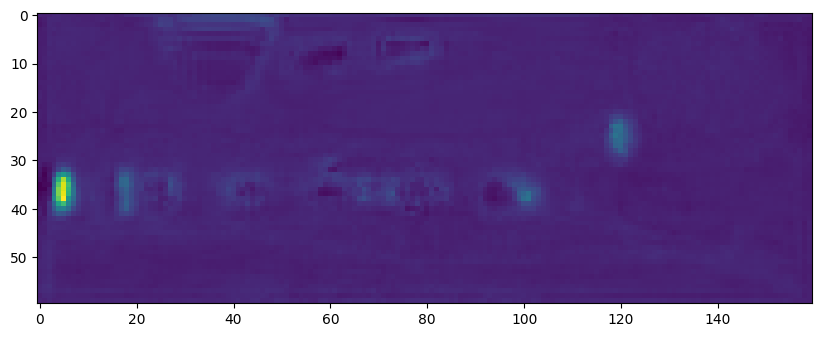

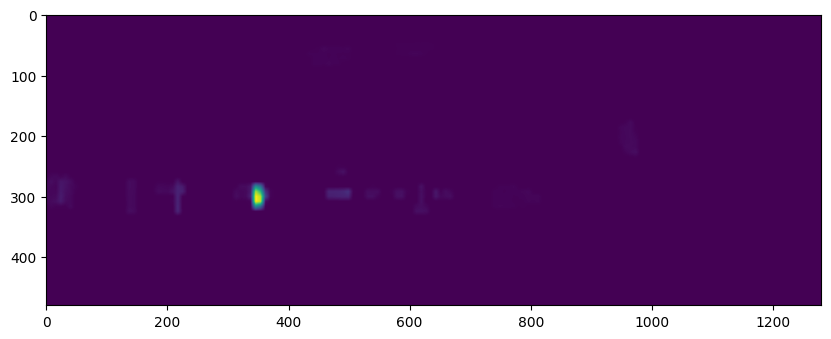

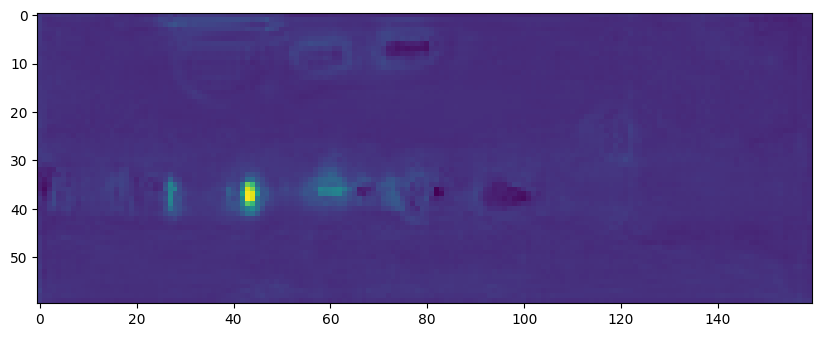

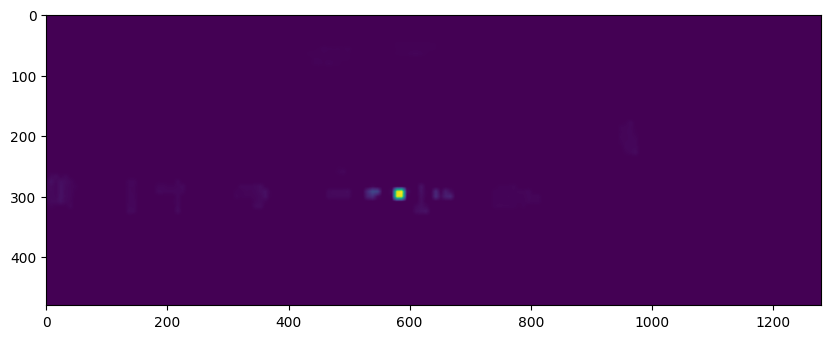

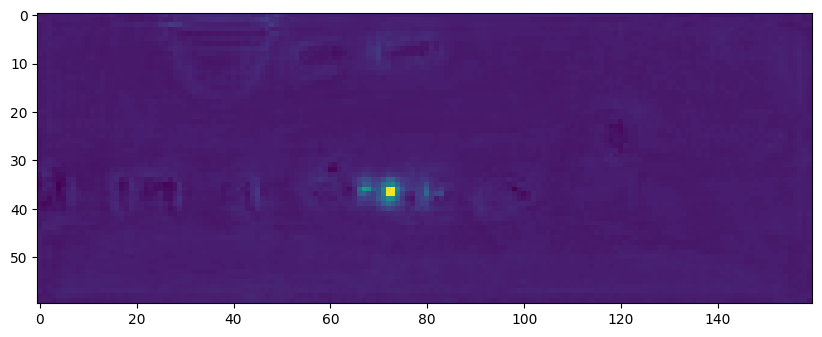

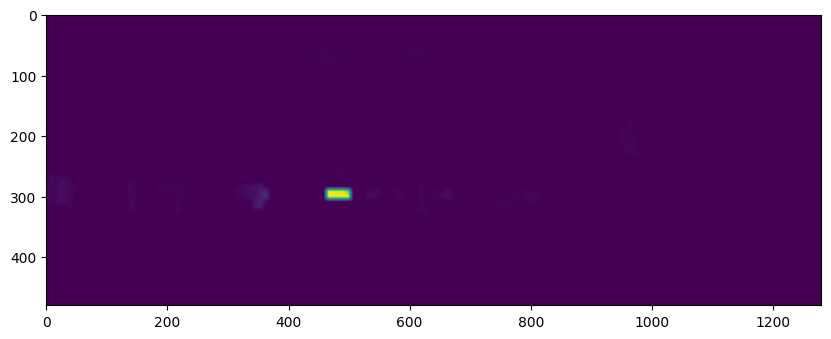

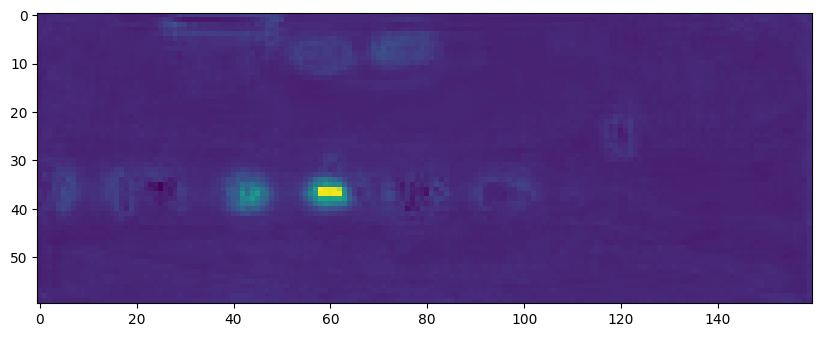

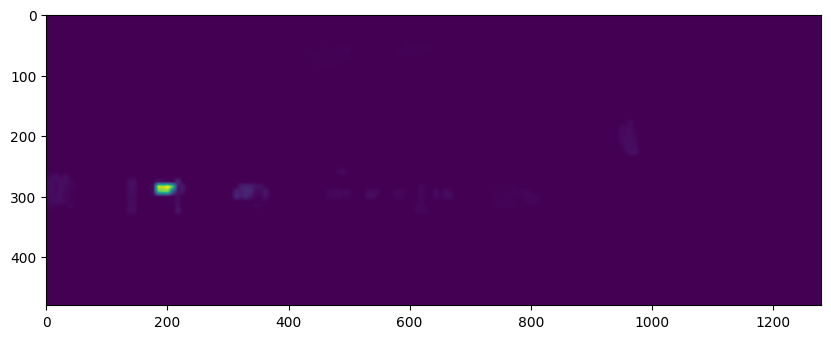

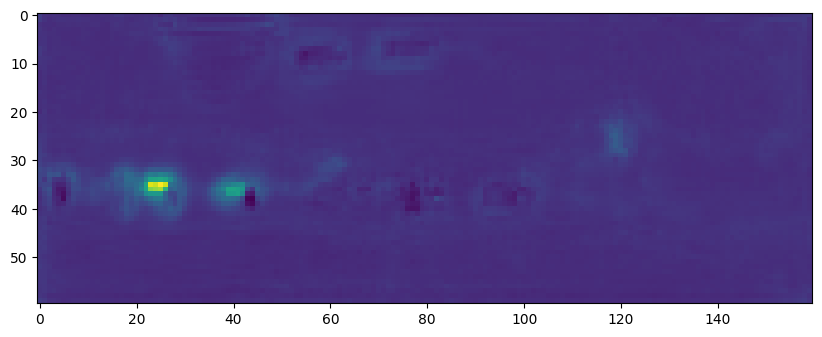

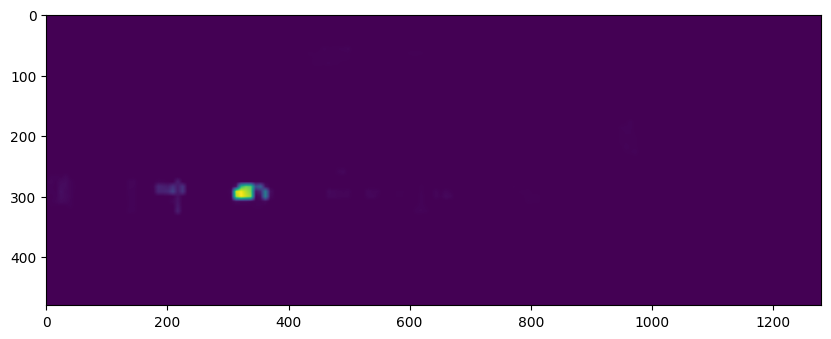

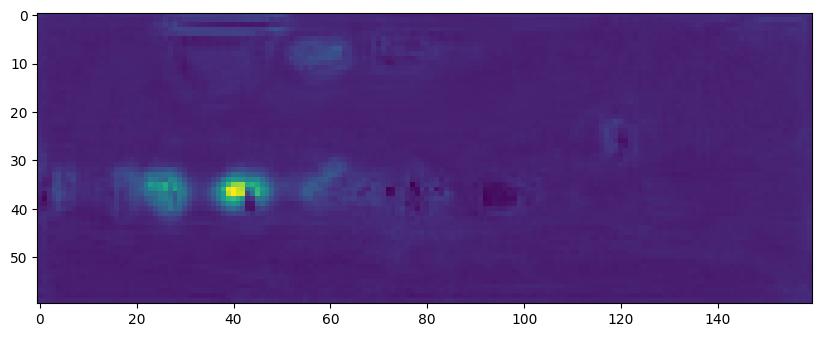

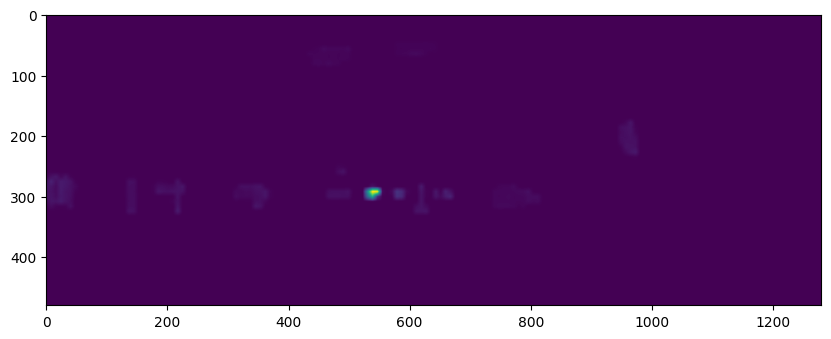

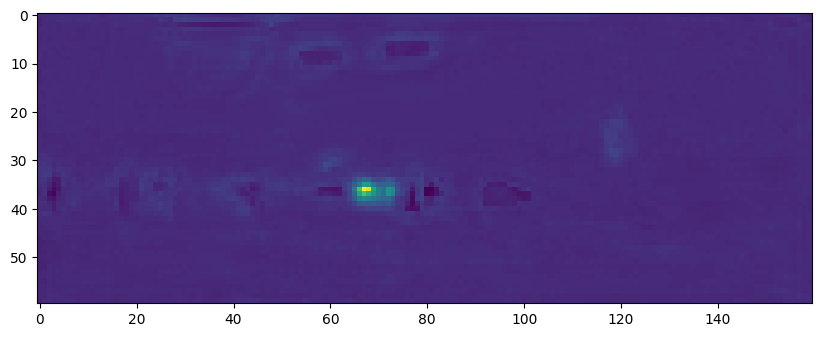

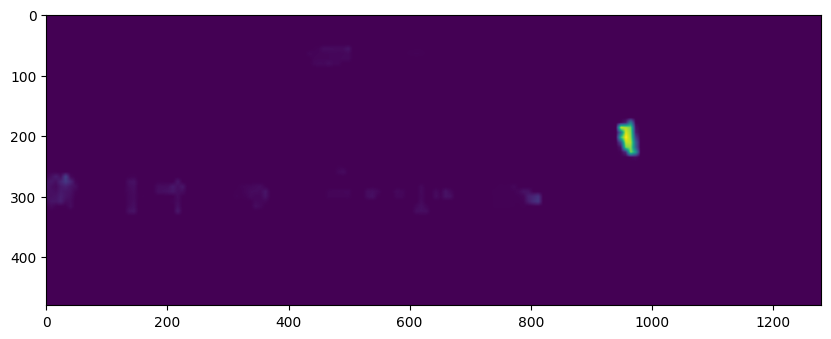

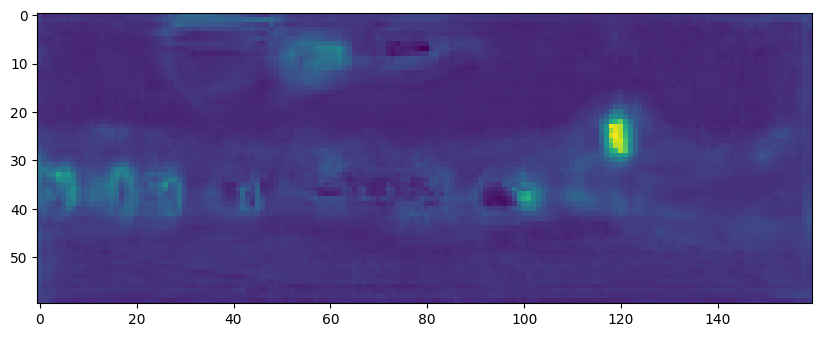

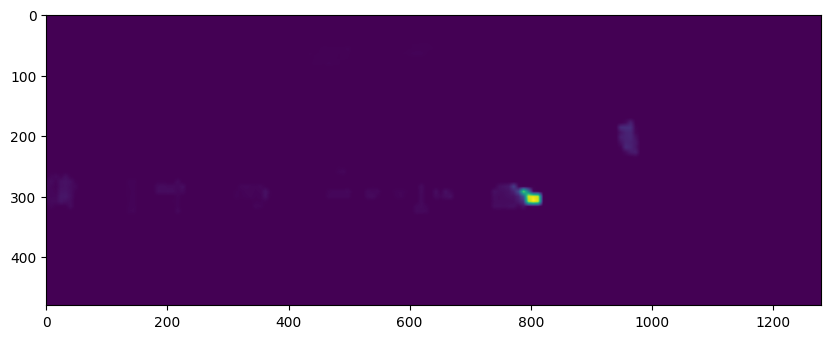

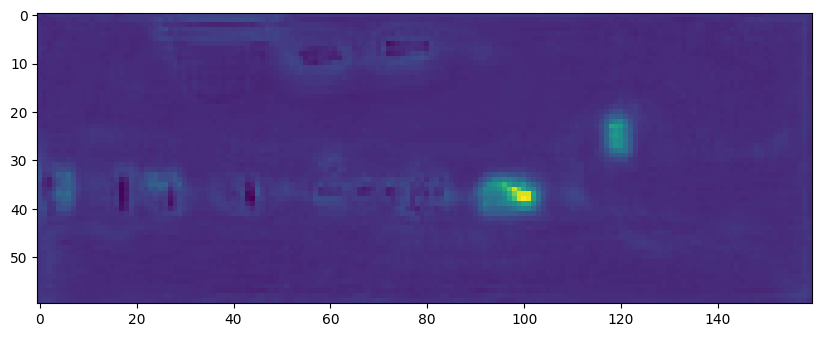

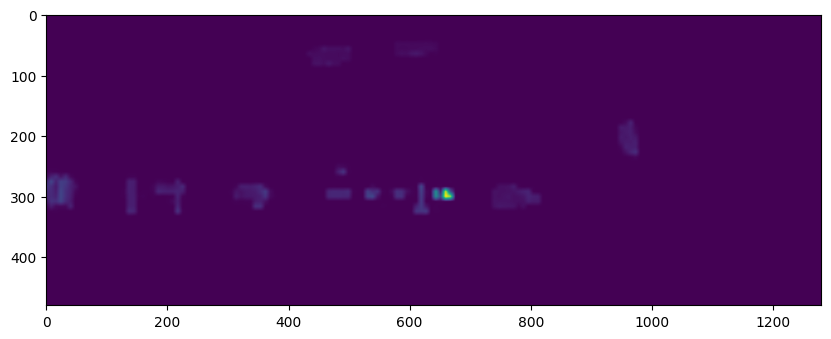

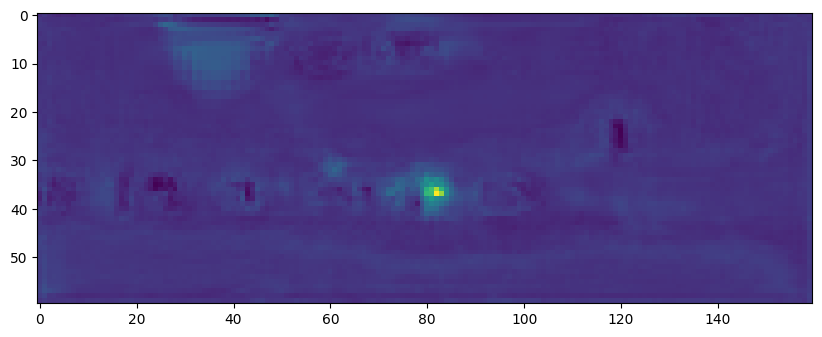

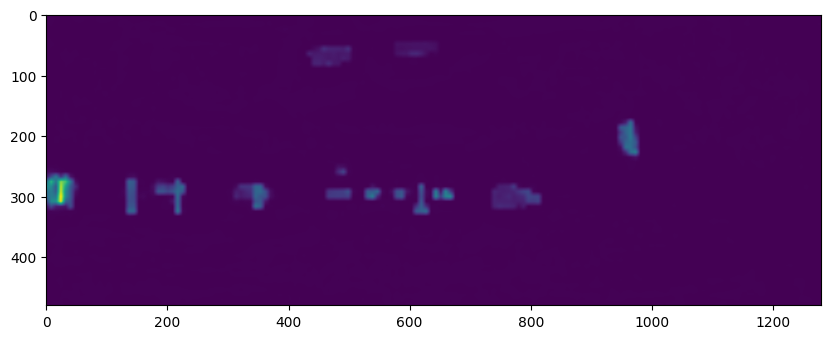

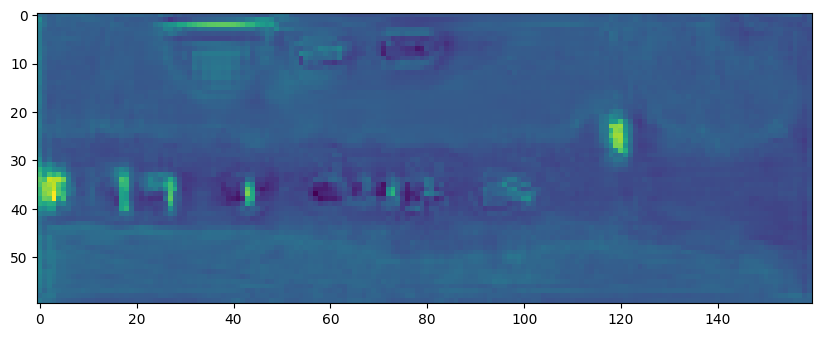

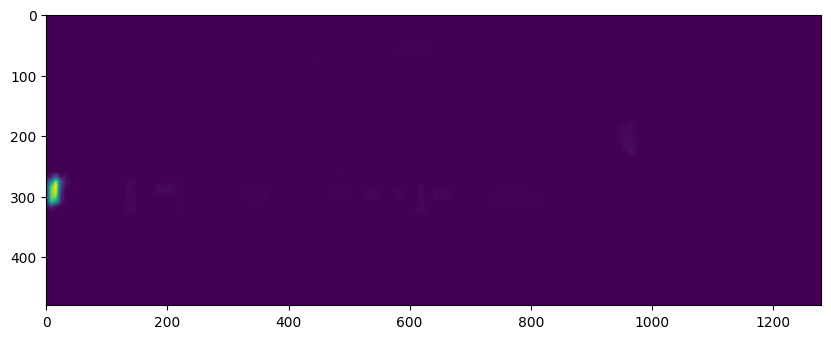

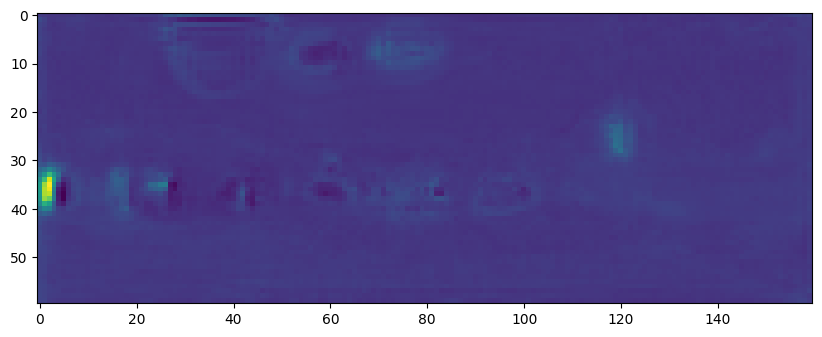

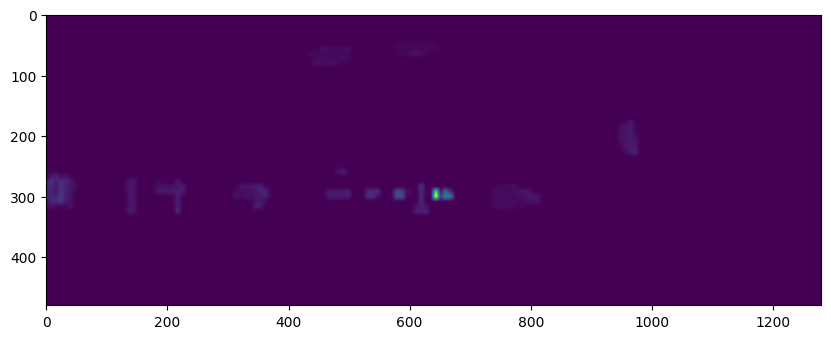

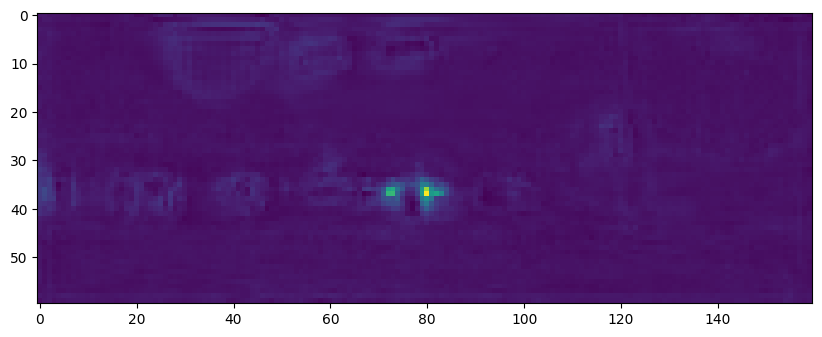

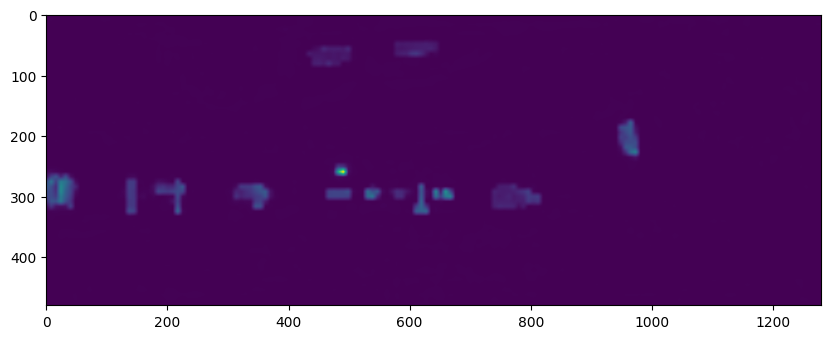

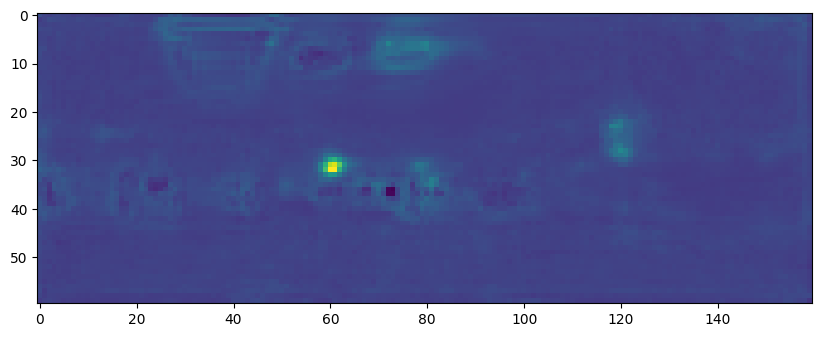

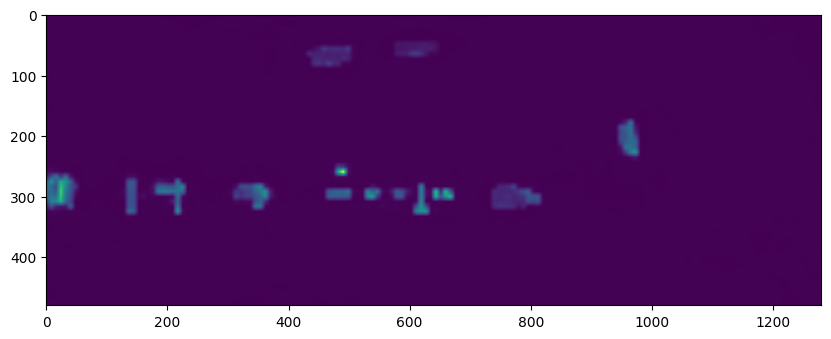

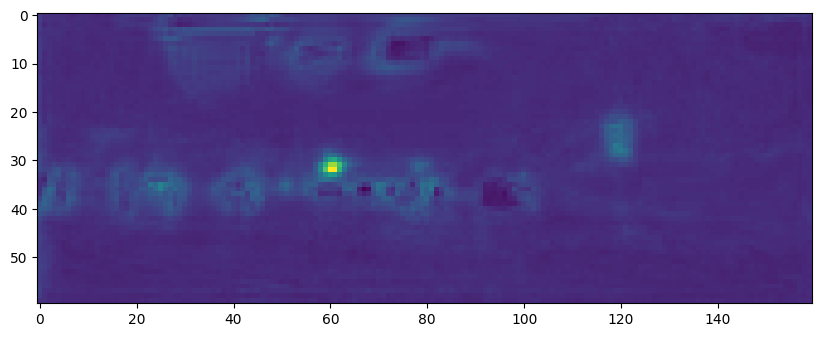

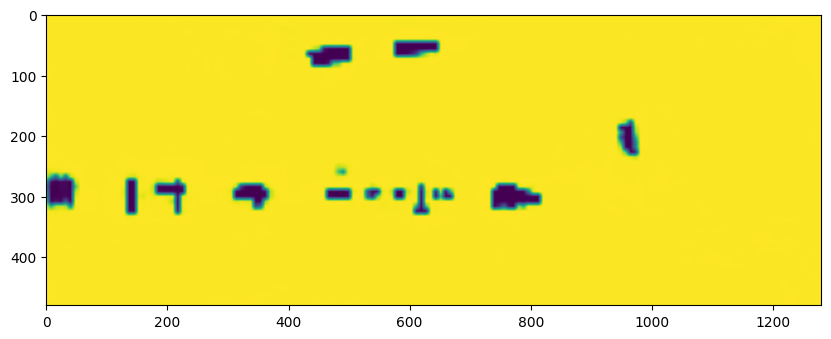

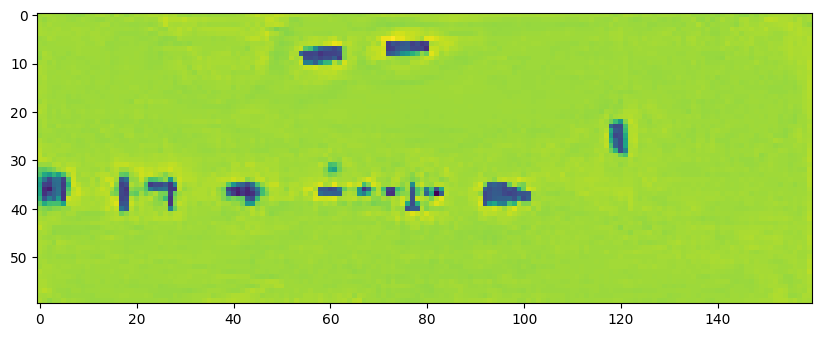

In [25]:
target_mask = re_mask[0,:,:,:]
target_vec = torch.cat((outputs[:,-256:],bg_vector.unsqueeze(0)),dim=0)
semseg = torch.einsum("cq,qhw->chw", target_vec, target_mask)
soft_seg = torch.nn.functional.interpolate(torch.nn.functional.softmax(semseg,dim=0).unsqueeze(0),size=(semseg.shape[1]*8,semseg.shape[2]*8),
                                                 mode='bilinear', align_corners=True).squeeze(0)
max_val, max_idx= torch.max(soft_seg,0)

target_outputs = outputs.cpu().detach().numpy()
target_img = (img[0,:,:,:].numpy().transpose(1, 2, 0)*255).astype(np.int16).copy()
xyxy = target_outputs[:,0:4]
cls = target_outputs[:,6].astype('int')
loc = target_outputs[:,7].astype('int')
action = target_outputs[:,8:].astype('int')


plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(target_img)
plt.show()   

plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(max_idx.cpu().detach().numpy())
plt.show()   
for i in range(xyxy.shape[0]+1):
    #print(i)

    #plot_one_box(xyxy[i], target_img, color=COLORS[cls[i]])
    
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(soft_seg[i,:,:].cpu().detach().numpy())
    plt.show()   
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(semseg[i,:,:].cpu().detach().numpy())
    plt.show()   
    
    

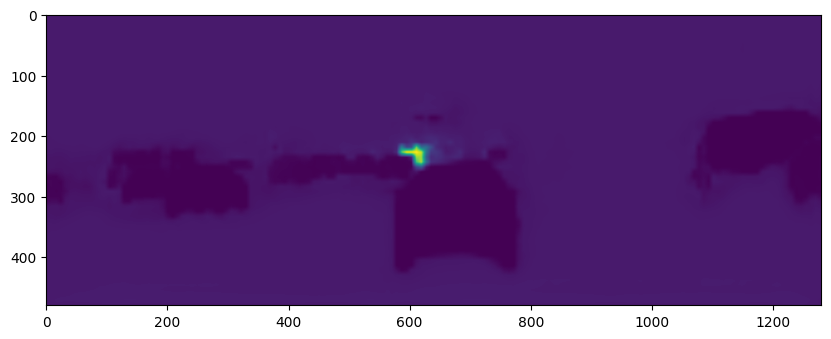

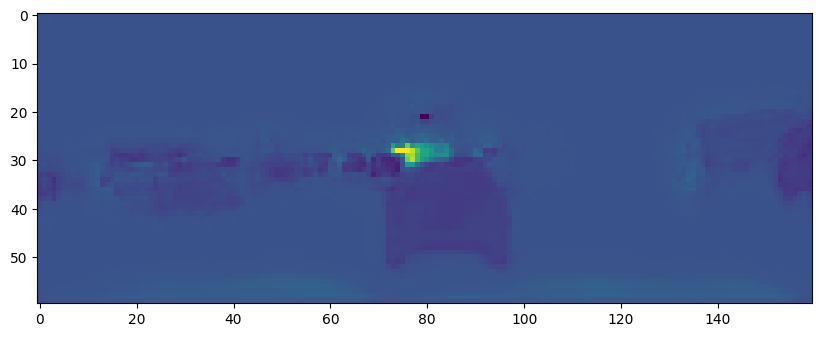

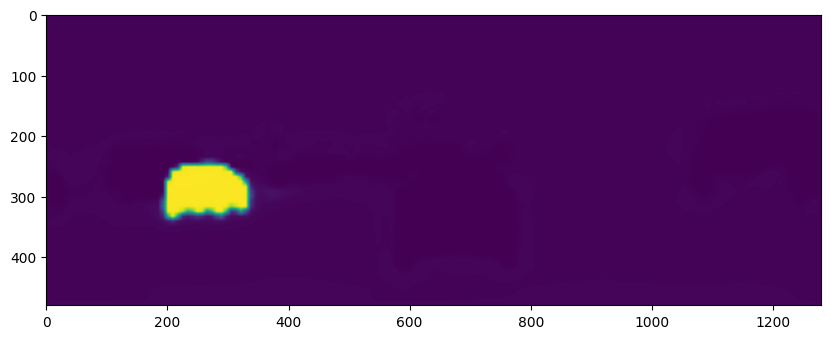

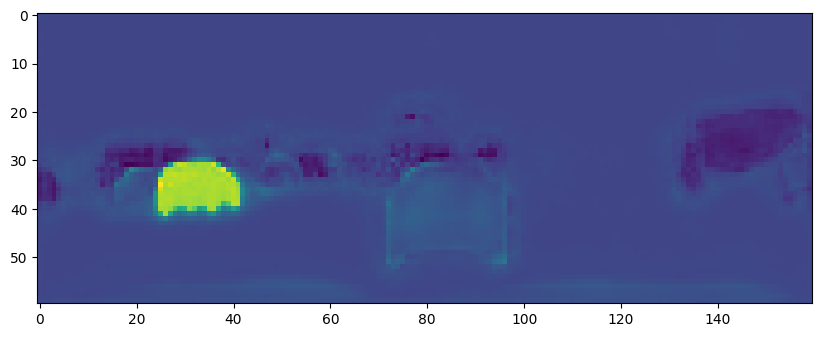

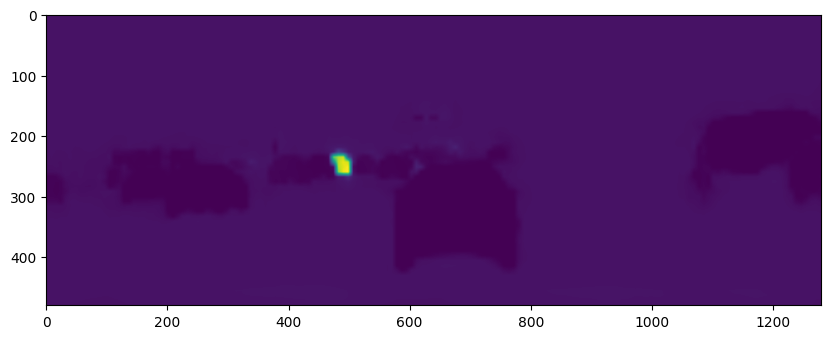

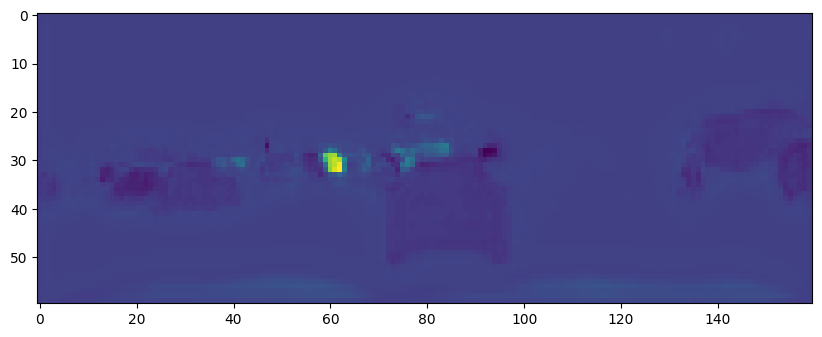

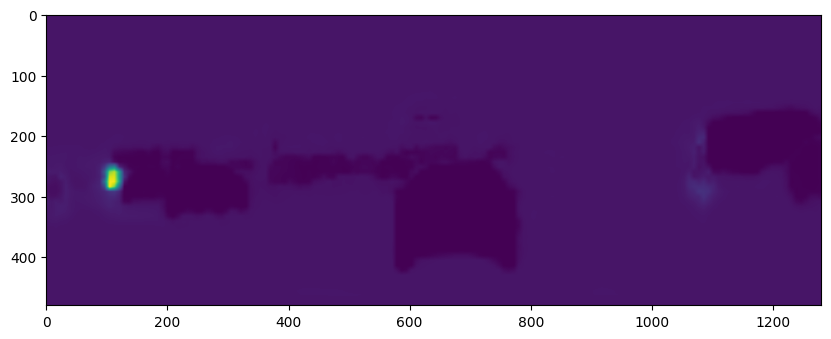

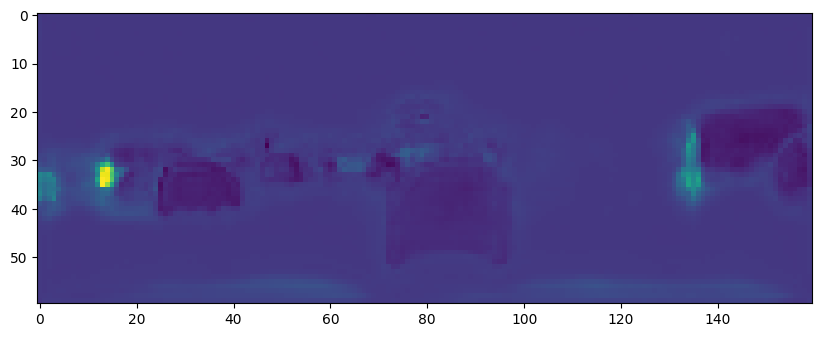

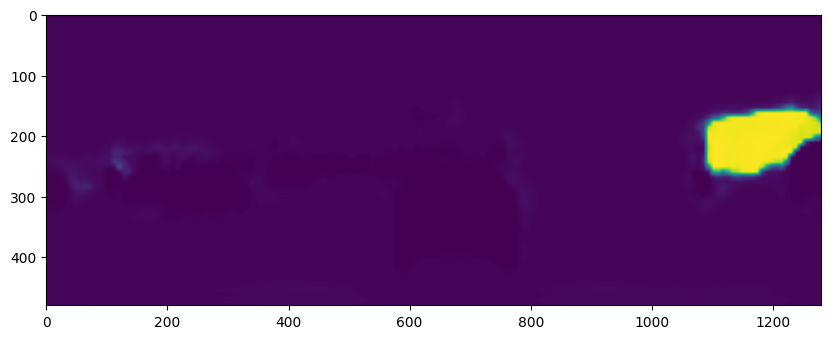

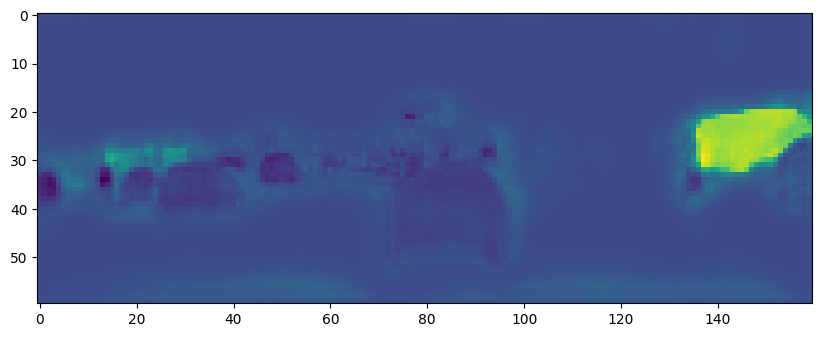

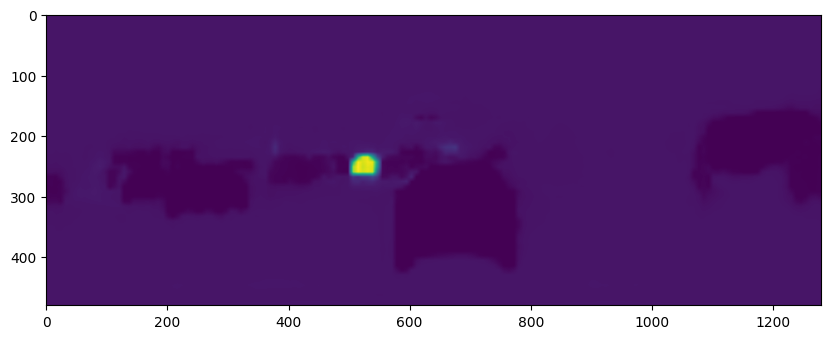

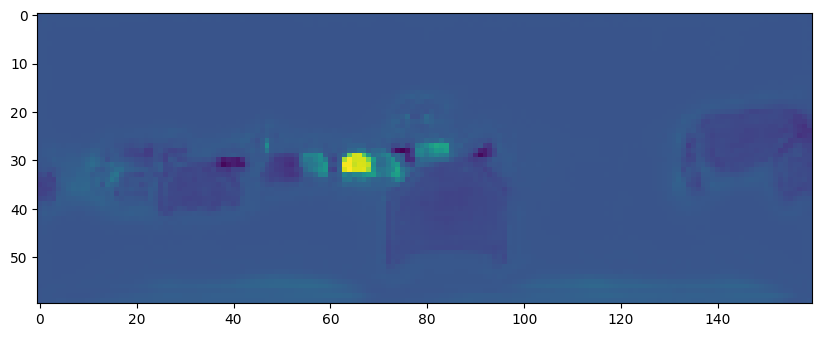

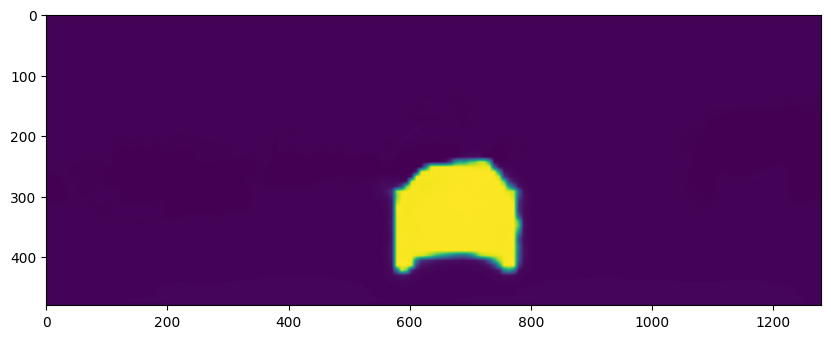

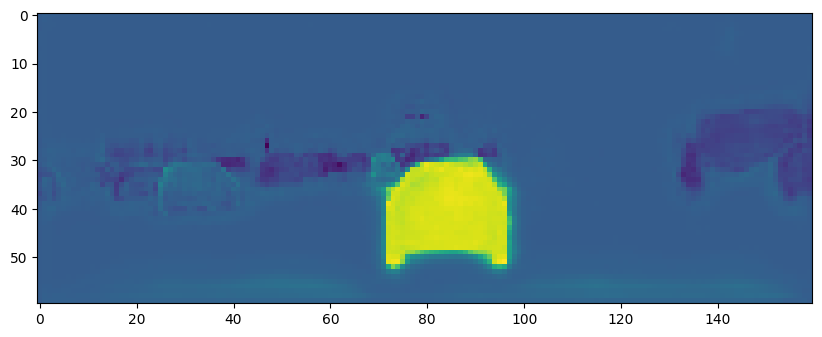

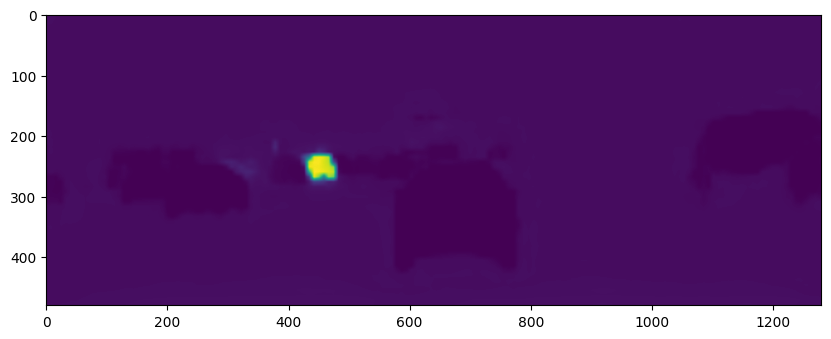

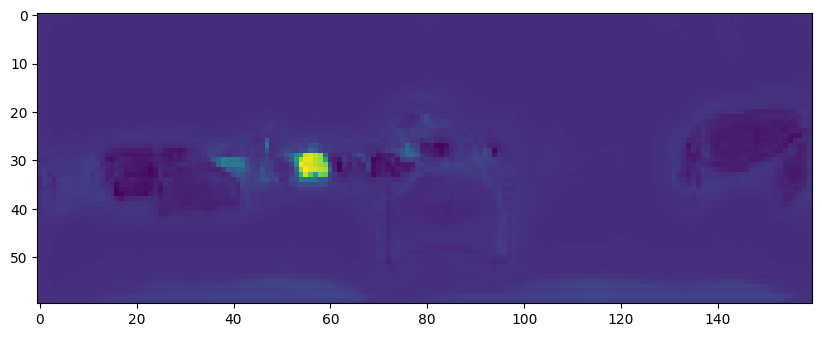

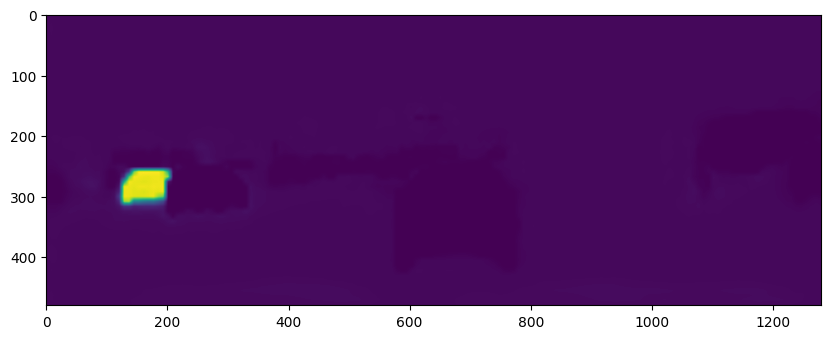

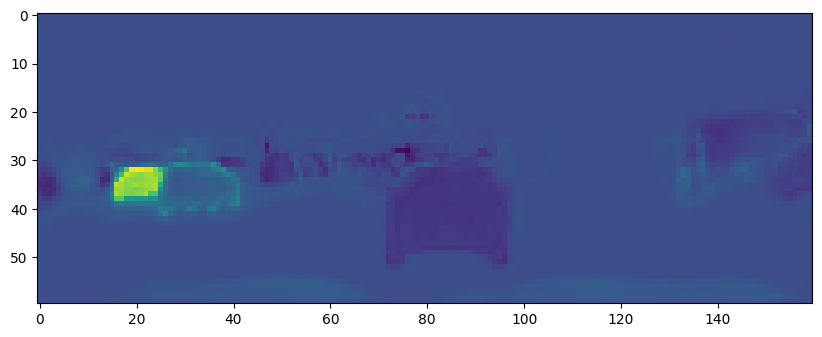

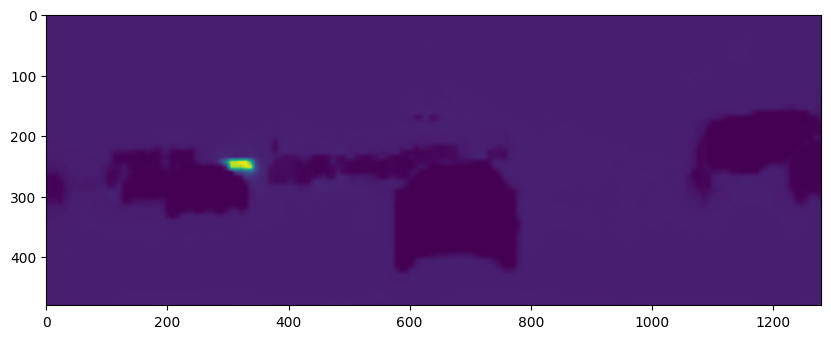

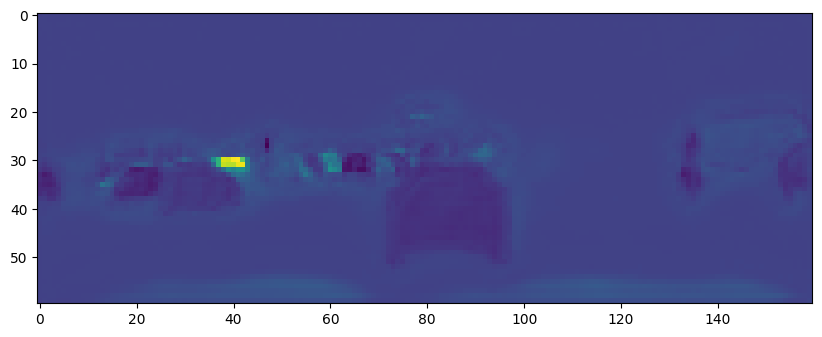

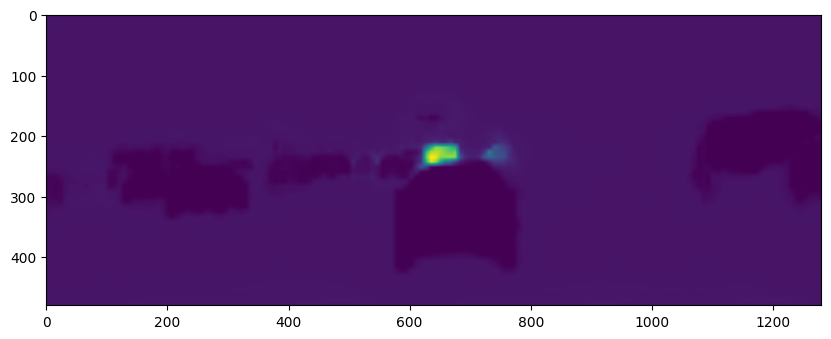

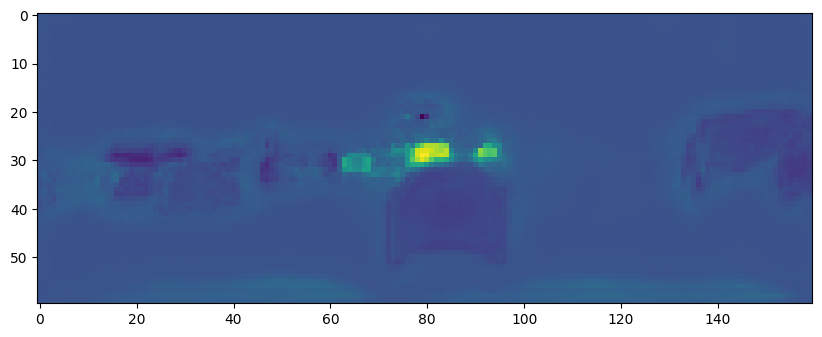

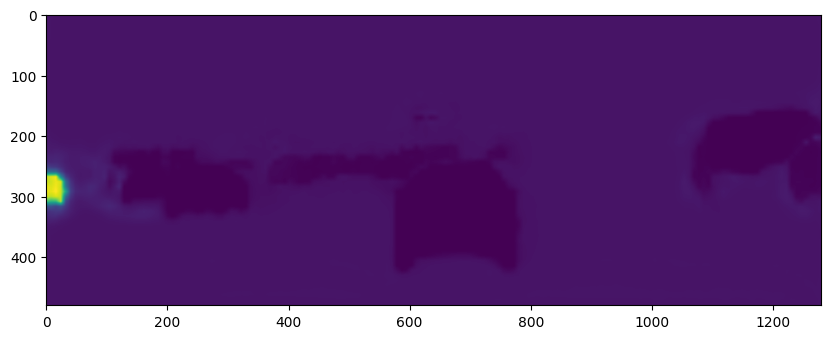

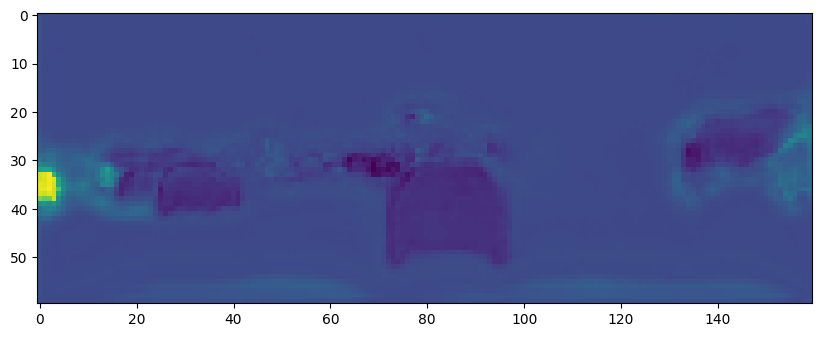

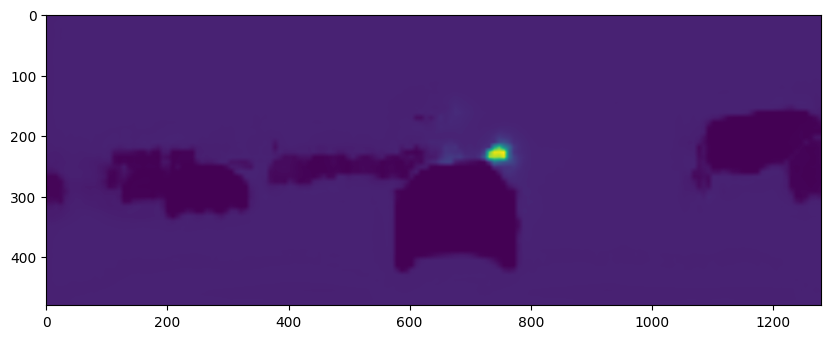

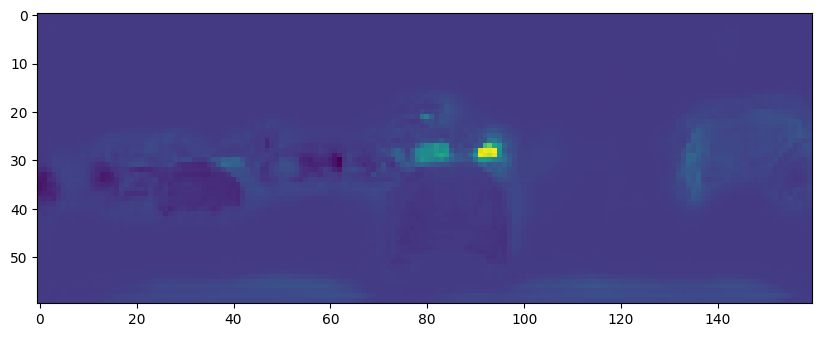

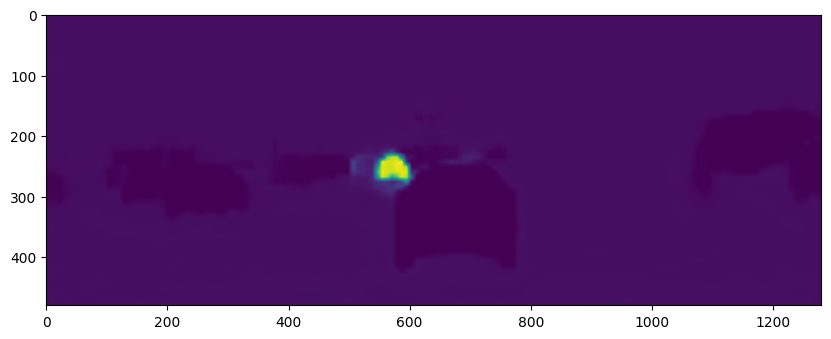

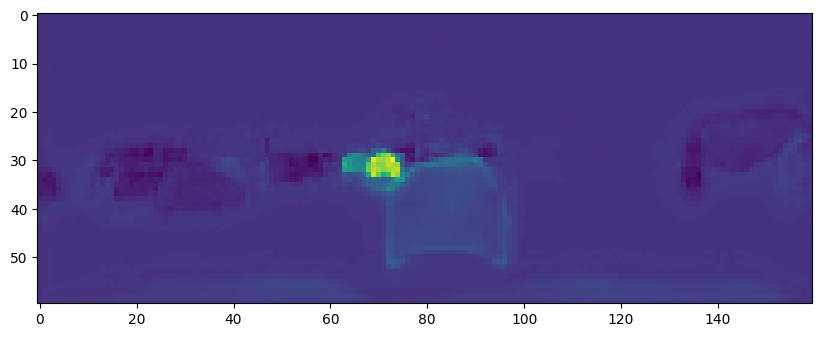

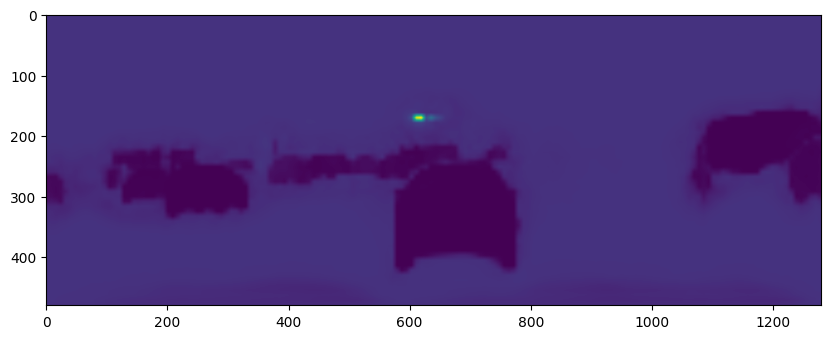

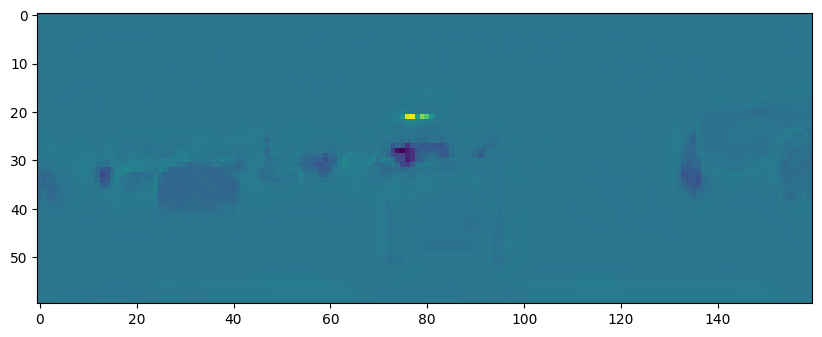

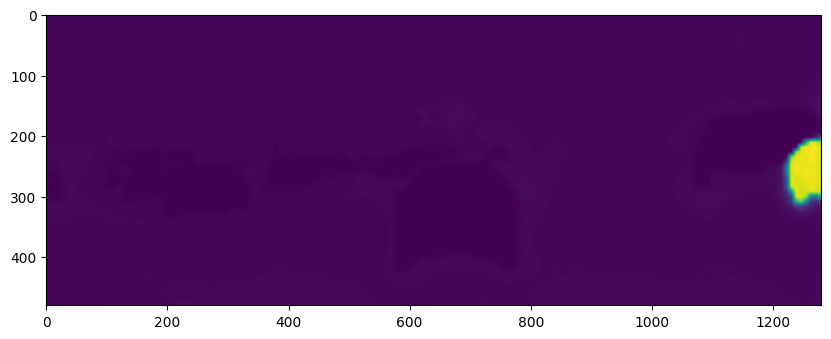

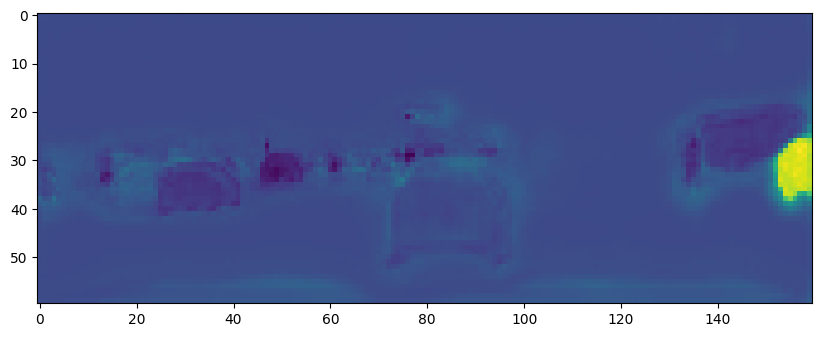

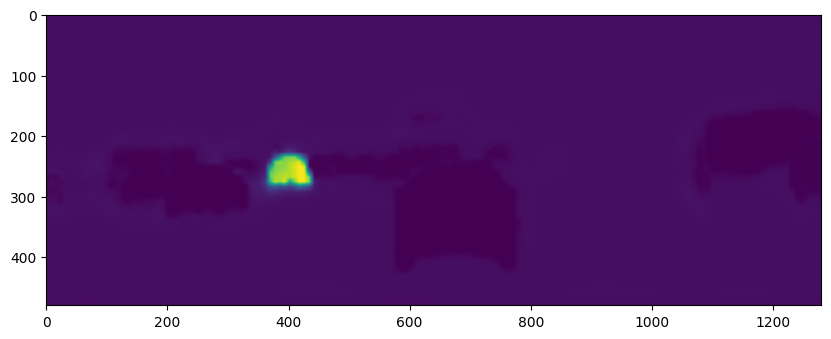

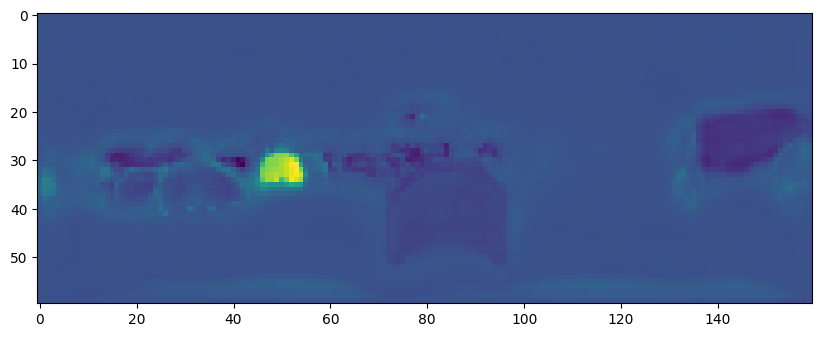

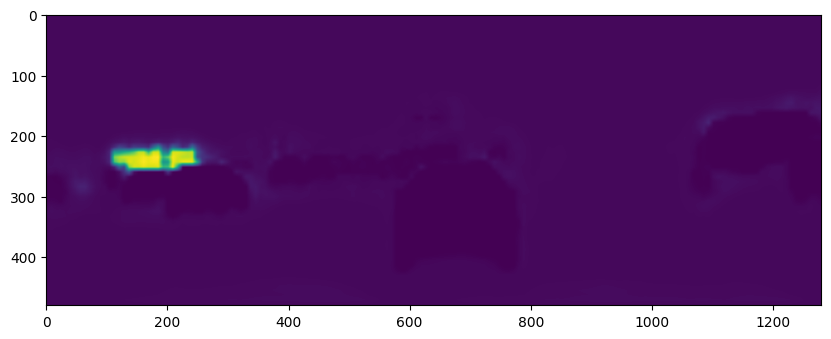

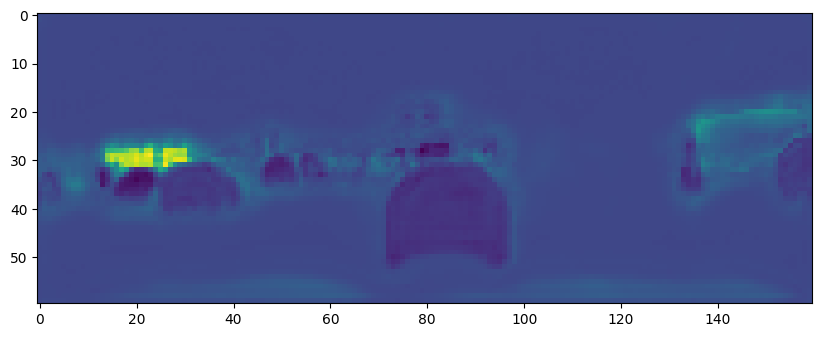

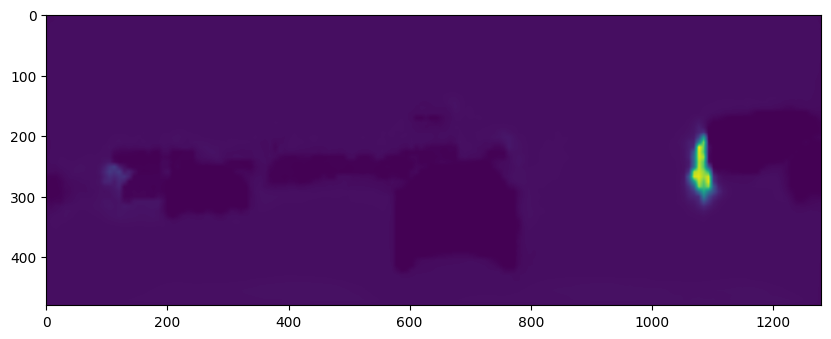

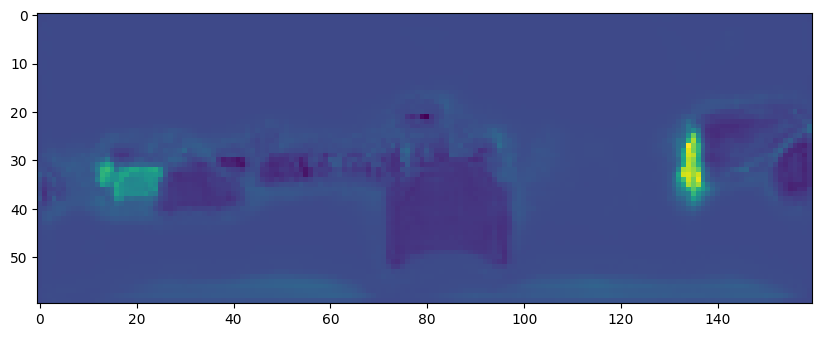

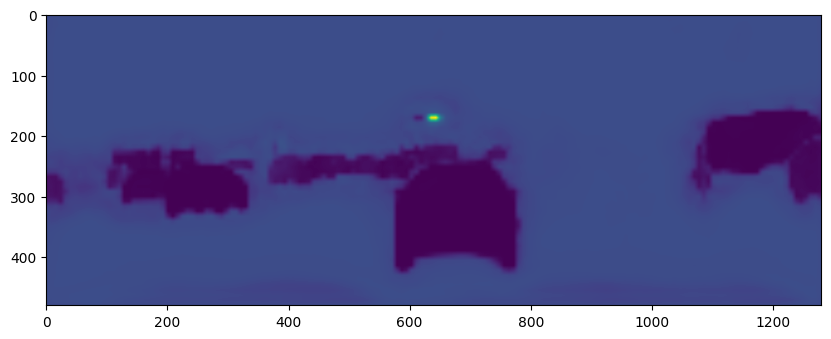

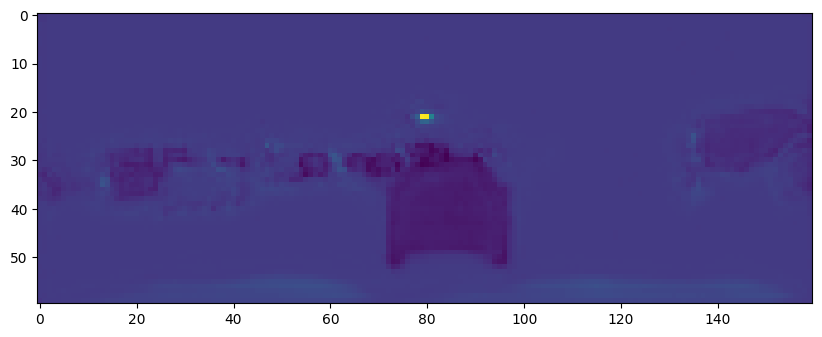

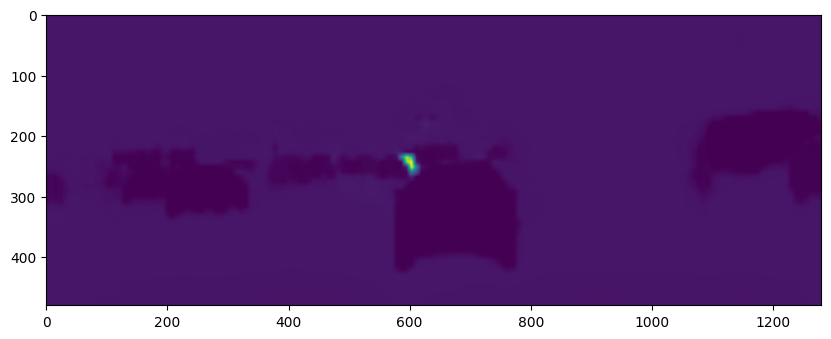

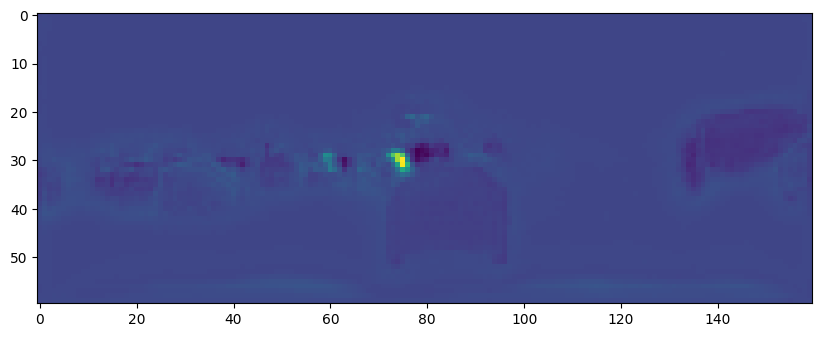

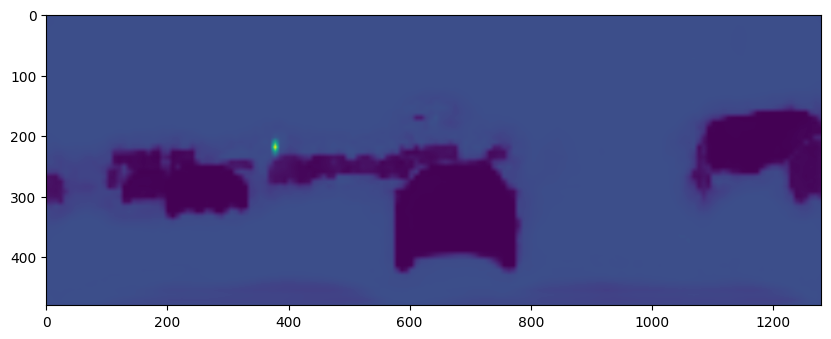

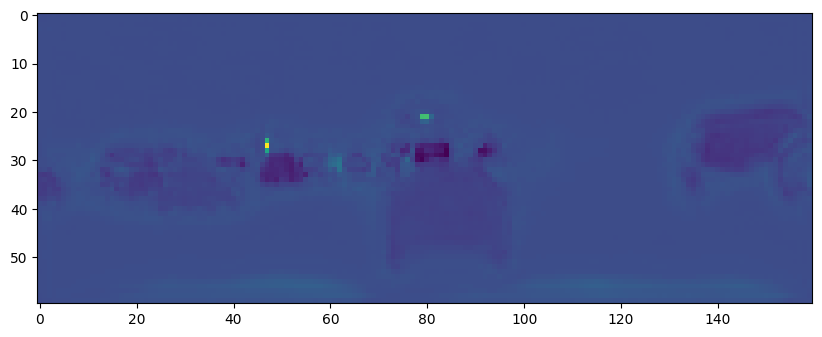

In [26]:
target_mask = re_mask[0,:,:,:]
target_vec = outputs[:,-256:]
semseg = torch.einsum("cq,qhw->chw", target_vec, target_mask)
soft_seg = torch.nn.functional.interpolate(torch.nn.functional.softmax(semseg,dim=0).unsqueeze(0),size=(semseg.shape[1]*8,semseg.shape[2]*8),
                                                 mode='bilinear', align_corners=True).squeeze(0)
max_val, max_idx= torch.max(soft_seg,0)

target_outputs = outputs.cpu().detach().numpy()
target_img = (img[0,:,:,:].numpy().transpose(1, 2, 0)*255).astype(np.int16).copy()
xyxy = target_outputs[:,0:4]
cls = target_outputs[:,6].astype('int')
loc = target_outputs[:,7].astype('int')
action = target_outputs[:,8:].astype('int')

for i in range(xyxy.shape[0]):
    #print(i)

    plot_one_box(xyxy[i], target_img, color=COLORS[cls[i]])
    
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(soft_seg[i,:,:].cpu().detach().numpy())
    plt.show()   
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(semseg[i,:,:].cpu().detach().numpy())
    plt.show()   
    
    

In [8]:
target_mask = re_mask[0,:,:,:]
target_vec = outputs[:,-256:]
semseg = torch.einsum("cq,qhw->chw", target_vec, target_mask)
soft_seg = torch.nn.functional.interpolate(torch.nn.functional.softmax(semseg,dim=0).unsqueeze(0),size=(semseg.shape[1]*8,semseg.shape[2]*8),
                                                 mode='bilinear', align_corners=True).squeeze(0)
max_val, max_idx= torch.max(soft_seg,0)

target_outputs = outputs.cpu().numpy()
target_img = (img[0,:,:,:].numpy().transpose(1, 2, 0)*255).astype(np.int16).copy()
xyxy = target_outputs[:,0:4]
cls = target_outputs[:,6].astype('int')
loc = target_outputs[:,7].astype('int')
action = target_outputs[:,8:].astype('int')

for i in range(xyxy.shape[0]):
    #print(i)

    plot_one_box_and_seg(xyxy[i],i, target_img,max_val.cpu().numpy(),max_idx.cpu().numpy(), color=COLORS[cls[i]])
    
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(soft_seg[i,:,:].cpu().detach().numpy())
    plt.show()   
    

NameError: name 're_mask' is not defined

In [ ]:
target_mask = re_mask[0,:,:,:]
target_vec = outputs[:,-256:]
semseg = torch.einsum("cq,qhw->chw", target_vec, target_mask)
soft_seg = torch.nn.functional.interpolate(torch.nn.functional.softmax(semseg,dim=0).unsqueeze(0),size=(semseg.shape[1]*8,semseg.shape[2]*8),
                                                 mode='bilinear', align_corners=True).squeeze(0)
semseg = torch.nn.functional.interpolate(semseg.unsqueeze(0),size=(semseg.shape[1]*8,semseg.shape[2]*8),
                                                 mode='bilinear', align_corners=True).squeeze(0)

max_val, max_idx= torch.max(soft_seg,0)


In [9]:
print(np.unique(max_idx.cpu().detach().numpy()))
print(xyxy.shape[0])

NameError: name 'max_idx' is not defined

In [10]:
target_outputs = outputs.cpu().detach().numpy()
target_img = (img[0,:,:,:].numpy().transpose(1, 2, 0)*255).astype(np.int16).copy()
xyxy = target_outputs[:,0:4]
cls = target_outputs[:,6].astype('int')
loc = target_outputs[:,7].astype('int')
action = target_outputs[:,8:].astype('int')
#print(xyxy.shape)
for i in range(xyxy.shape[0]):
    #print(i)

    plot_one_box(xyxy[i], target_img, color=COLORS[cls[i]])
    
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(soft_seg[i,:,:].cpu().detach().numpy())
    plt.show()   
    
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(max_idx.cpu().detach().numpy())
plt.show() 
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(target_img)
plt.show() 

NameError: name 'outputs' is not defined

In [18]:
max_val, max_idx= torch.max(soft_seg,0)

In [21]:
print(np.max(img[0,:,:,:].numpy().transpose(1, 2, 0)*255))

254.00002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


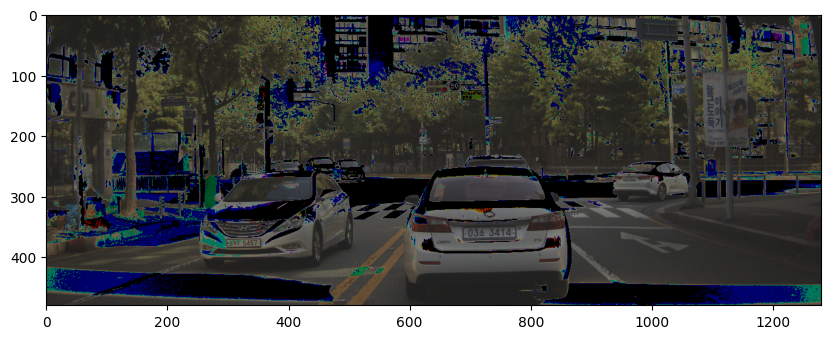

tensor([[587.0612, 235.2967, 868.7459, 468.6555,   1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)


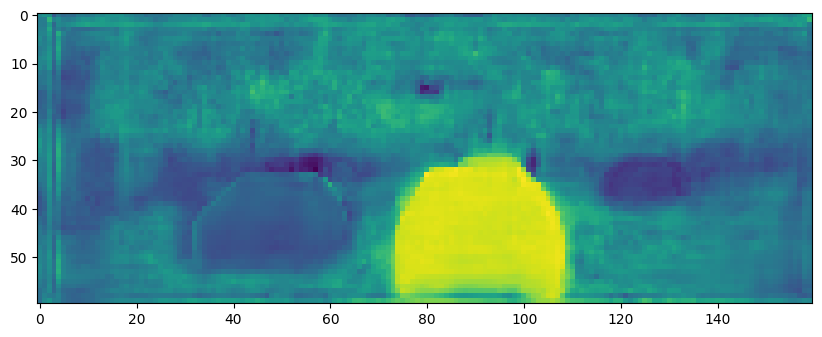

tensor([[427.4144, 233.6781, 479.9054, 269.7332,   0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)


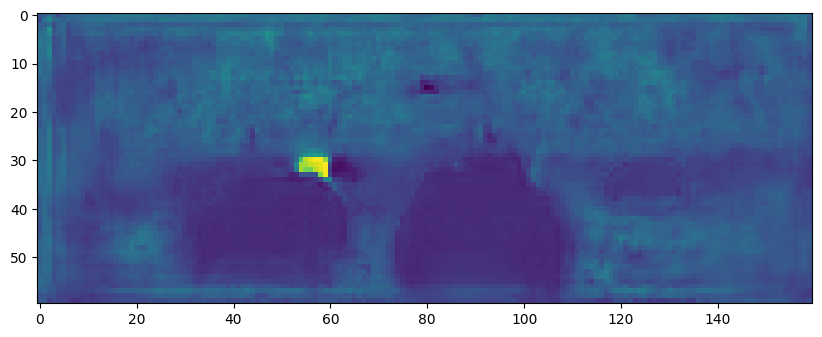

tensor([[249.8779, 255.9334, 511.4481, 418.3855,   1.0000]], device='cuda:0',
       grad_fn=<SliceBackward0>)


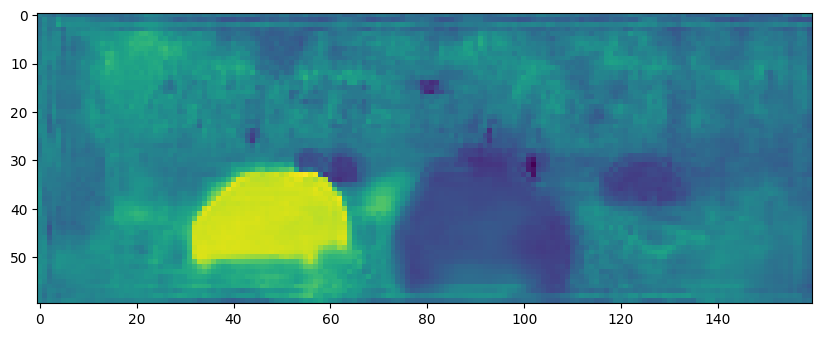

tensor([[9.3325e+02, 2.4139e+02, 1.0648e+03, 3.0958e+02, 9.9996e-01]],
       device='cuda:0', grad_fn=<SliceBackward0>)


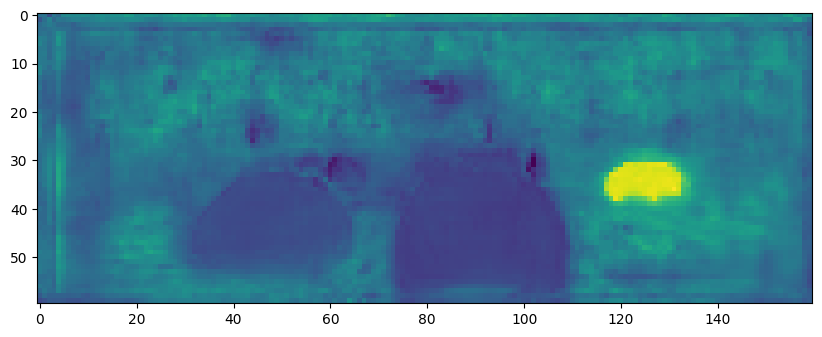

tensor([[471.7422, 237.7109, 528.4623, 279.1551,   0.9997]], device='cuda:0',
       grad_fn=<SliceBackward0>)


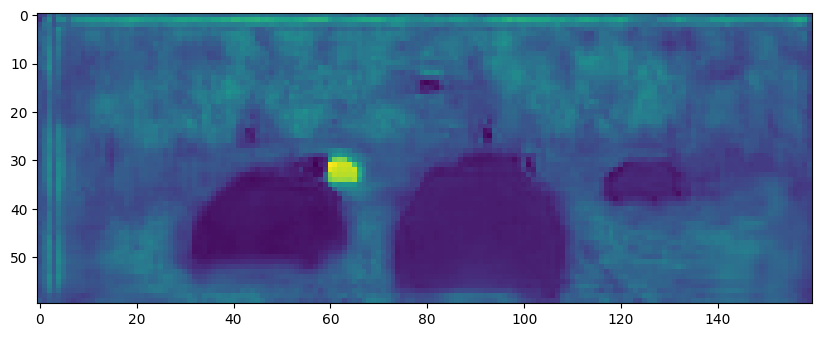

tensor([[805.3619, 231.8628, 822.5836, 271.3974,   0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)


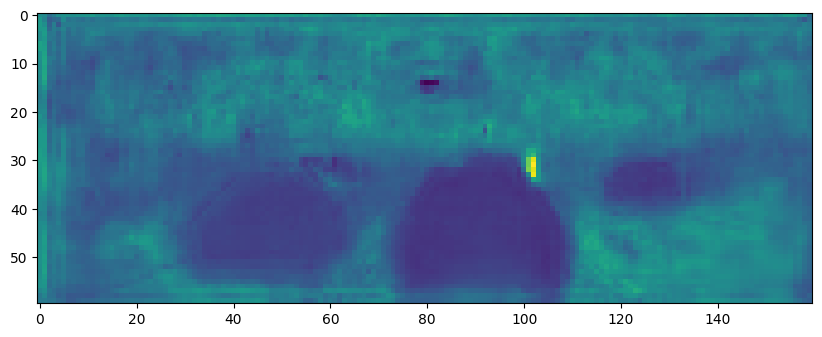

tensor([[736.5097, 185.3350, 745.4254, 204.7005,   0.9975]], device='cuda:0',
       grad_fn=<SliceBackward0>)


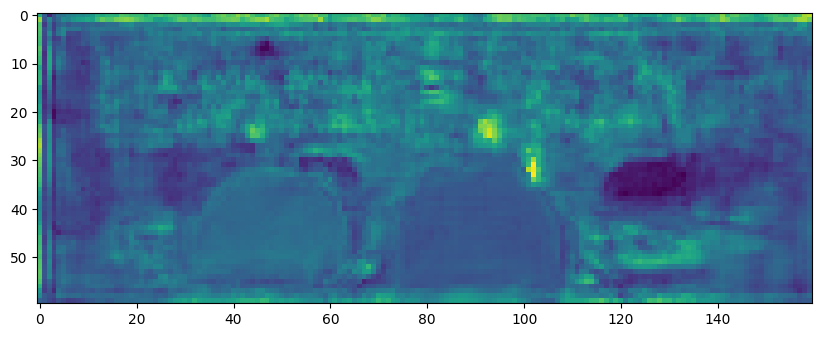

tensor([[627.0908, 108.8440, 664.0161, 121.0101,   0.9999]], device='cuda:0',
       grad_fn=<SliceBackward0>)


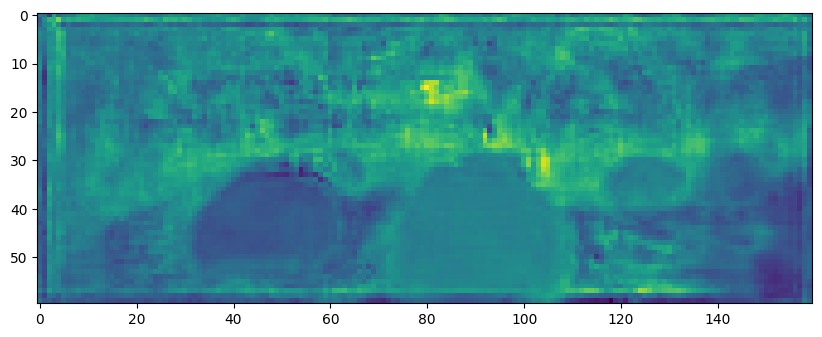

tensor([[626.8935, 118.5516, 663.8696, 128.9127,   0.9941]], device='cuda:0',
       grad_fn=<SliceBackward0>)


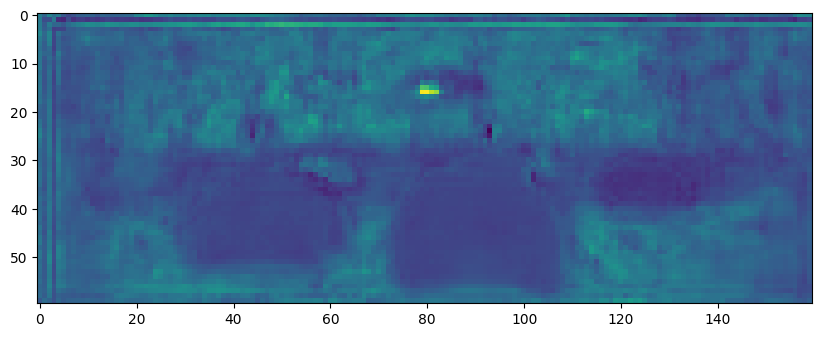

tensor([[347.0935, 188.6674, 357.5732, 209.0945,   0.7799]], device='cuda:0',
       grad_fn=<SliceBackward0>)


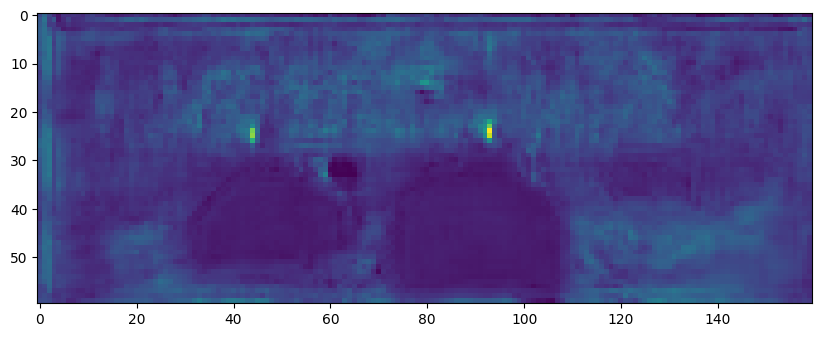

In [22]:
target_mask = re_mask[0,:,:,:]
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow((img[0,:,:,:].numpy().transpose(1, 2, 0)))
plt.show()   
for ii in range(outputs.shape[0]):
    print(outputs[ii:ii+1,:5])
    target_vec = outputs[ii:ii+1,-256:]
    semseg = torch.einsum("cq,qhw->chw", target_vec, target_mask)
    
    
    plt.rcParams['figure.figsize'] = [10,10]
    plt.imshow(semseg.squeeze(0).cpu().detach().numpy())
    plt.show()   

In [21]:
print(img[0,:,:,:])

tensor([[[-1.5357, -1.5528, -1.6042,  ..., -1.3130, -1.3130, -1.3130],
         [-1.5870, -1.5699, -1.6213,  ..., -1.3130, -1.3302, -1.3302],
         [-1.6042, -1.6042, -1.6042,  ..., -1.3302, -1.3473, -1.3473],
         ...,
         [-0.0972, -0.1143, -0.2171,  ..., -0.3369, -0.0629, -0.2342],
         [-0.1657, -0.1486, -0.2856,  ..., -0.3883, -0.3369, -0.3541],
         [-0.2342, -0.2342, -0.3198,  ...,  0.6221,  0.7591,  0.5536]],

        [[-1.3354, -1.3529, -1.3704,  ..., -0.9328, -0.9328, -0.9328],
         [-1.3880, -1.3704, -1.3880,  ..., -0.9328, -0.9503, -0.9503],
         [-1.4055, -1.4055, -1.4055,  ..., -0.9503, -0.9503, -0.9503],
         ...,
         [ 0.2227,  0.2052,  0.0826,  ..., -0.0574,  0.1877,  0.0126],
         [ 0.1527,  0.1702,  0.0126,  ..., -0.1800, -0.1975, -0.2150],
         [ 0.0826,  0.0826, -0.0574,  ...,  0.8704,  0.8880,  0.6779]],

        [[-1.2641, -1.2816, -1.2816,  ..., -0.6715, -0.6715, -0.6715],
         [-1.2816, -1.2641, -1.2990,  ..., -0

In [10]:
outputs = postprocess(result, 35, exp.test_conf, exp.nmsthre)

/tmp/ipykernel_1238501/3983550276.py:27: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  action_idx = (image_pred[:, 5+7+9 : 5 + 7 + 9+19]+0.6)//1


In [11]:
print(outputs[0].shape)

torch.Size([2, 283])


In [38]:
target_vec = outputs[1][0:1,-256:]
print(target_vec.shape)

torch.Size([1, 256])


In [39]:
target_mask = re_mask[1,:,:,:]

In [40]:
print(target_mask.shape)

torch.Size([256, 60, 160])


In [41]:
semseg = torch.einsum("cq,qhw->chw", target_vec, target_mask)

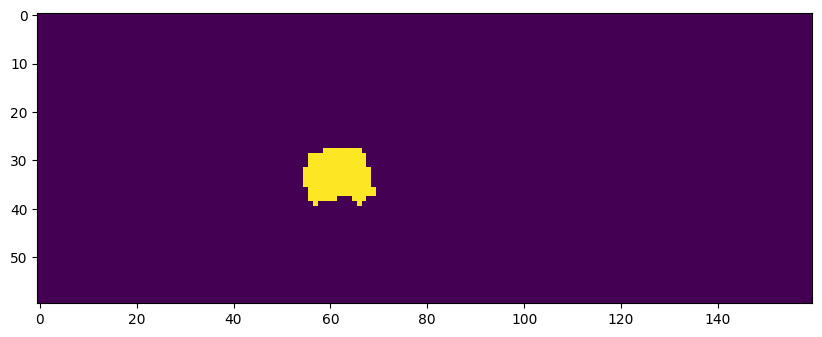

In [49]:

plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(semseg.squeeze(0).cpu().detach().numpy()>3)
plt.show()   

In [44]:
np.max(semseg.squeeze(0).cpu().detach().numpy())

5.3930936

In [24]:
print(torch.sum(reid_feat>0.00001,dim=1))


tensor([ 4,  5,  4,  7,  7,  5,  6,  8,  3,  7, 92], device='cuda:0')
torch.Size([11, 256])


In [13]:
aa = torch.rand([10,10,10])

In [14]:
print(aa)

tensor([[[1.0032e-01, 9.7745e-01, 1.7068e-01, 7.7974e-02, 7.7774e-01,
          6.7228e-02, 5.7599e-01, 4.8174e-01, 6.8782e-01, 5.8215e-01],
         [5.3877e-02, 4.8938e-01, 3.8743e-02, 3.6978e-01, 8.3786e-02,
          9.6735e-01, 2.0704e-01, 1.5215e-01, 8.7950e-02, 5.1983e-01],
         [9.0351e-01, 5.1533e-01, 9.5289e-01, 4.3882e-01, 1.1208e-01,
          7.8655e-01, 1.5088e-01, 1.2749e-01, 1.2550e-01, 6.7269e-02],
         [3.9792e-01, 9.1806e-01, 7.1954e-02, 4.8304e-02, 8.6836e-01,
          2.9321e-01, 9.1225e-01, 3.5346e-04, 5.6389e-01, 1.2315e-01],
         [4.2732e-01, 2.6112e-01, 7.0063e-01, 5.2287e-01, 9.7503e-01,
          6.3035e-01, 4.0203e-01, 3.5093e-02, 2.3883e-01, 8.4450e-01],
         [3.7273e-01, 6.5374e-01, 3.9779e-01, 6.1454e-01, 4.9509e-01,
          7.4053e-02, 7.3397e-01, 4.8751e-01, 1.7052e-01, 4.1359e-01],
         [9.4668e-01, 1.8981e-01, 6.0063e-01, 2.3469e-01, 5.8526e-01,
          5.1318e-01, 8.0281e-01, 9.8240e-01, 1.2828e-01, 6.4122e-01],
         [4.3

In [18]:
bb = aa[:,:,4].unsqueeze(2)*aa[:,:,5:10]

In [17]:
aa[:,:,4].repeat(1,1,5).shape

torch.Size([1, 10, 50])